# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [173]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


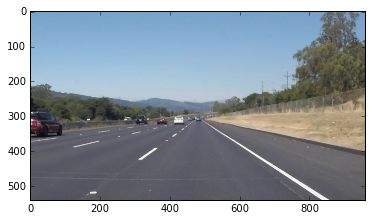

In [174]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [194]:
import math
from sklearn.cluster import KMeans

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def kmeans_clustering(l, i):
    # That function gets a list of lenghts of each line and a list of calculated x interesection for each line
    # Try to classify each point (pair intersect-lenght) in 2 groups
    # We will get the group with strongest line, in that case the longest
    X = [[a,b] for (a,b)  in zip(i,l)]
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    labels = kmeans.fit_predict(X)
    #plt.scatter(i,l, c= labels)
    
    # get class for the longest line, and chose elements of same class:
    #-----------------------------------------
    #max_d_index = l.index(max(l))
    #max_d = l[max_d_index]
    #i_max_d = i[max_d_index]
    #label_max_lenght = labels[max_d_index]
    #index = np.where(labels == label_max_lenght)
    #return index of elements belonging to the selected class:
    #return(index)   
    
    # get class with maximum average lenght per line:
    #-----------------------------------------
    index_0 = np.where(labels == 0)
    index_1 = np.where(labels == 1)
    c0 = np.mean(np.array(l)[index_0])
    c1 = np.mean(np.array(l)[index_1])
    if c0 >= c1:
        return(index_0)
    else:
        return(index_1)
    
    


def draw_lines(img, lines, color=[255, 0, 0], thickness=12):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    

    # version with k means:
    m_left_list = []
    x_intercept_left = []
    lengths_left = []
    
    m_right_list = []
    x_intercept_right = []
    lengths_right = []
    
    imshape = img.shape
    ysize = imshape[0]
    xsize = imshape[1]
    
    reshaper = 1.60
    y_top = ysize / reshaper
    coefficient_of_variation = 0.015
    
    for line in lines:
        for x1,y1,x2,y2 in line: 
            
            if x2!=x1: # Avoiding dividing by zero
                m = (y2-y1) / (x2-x1) 
                print(m)
                # Applying some slope selection, in order to avoid horizontal lines and too much vertical ones
                if (np.absolute(m) >= 0.60): # & (np.absolute(m) <= 0.9)
                    # calculating the length of the line:
                    d = np.sqrt((y2-y1)**2+(x2-x1)**2)
                    
                    if (m>0) & (x1 >= xsize/2) : #Right lane line
                        b = y2 - m*x2
                        x_intercept = (ysize - b) / m 
                        #here we discard lines that have some intersetc out of our x axis size:
                        if(x_intercept>=0) & (x_intercept<=xsize):
                            m_right_list.append(m)
                            lengths_right.append(d)
                            x_intercept_right.append(x_intercept)
                    elif (m<0) & (x1 <= xsize/2): # left lane line
                        b = y2 - m*x2
                        x_intercept = (ysize - b) / m
                        if(x_intercept>=0) & (x_intercept<=xsize):
                            m_left_list.append(m)
                            lengths_left.append(d)
                            x_intercept_left.append(x_intercept)                
    
    #calculate right line:
    if (len(m_right_list)>0) & (len(x_intercept_right)>0):
        # here we calculate the total mean for slopes and interpepts for right lane
        m = np.mean(m_right_list)
        x_intercept_avg = np.mean(x_intercept_right)
        std = np.std(x_intercept_right)
        
        
        # if there are more than 2 lines, we try to choose right ones with a clustering technique
        if (len(x_intercept_right)>1) & (std / xsize > coefficient_of_variation):
            #print('----------------------')
            #print('LENGHTS: ', lengths_right )
            #print('INTER: ', x_intercept_avg, x_intercept_right)
            #print(x_intercept_avg,std, std / np.fabs(xsize), xsize)

            index_filtering = kmeans_clustering(lengths_right, x_intercept_right)
            # updating m and x_intercept_avg with selected lines:
            m = np.mean(np.array(m_right_list)[index_filtering])
            x_intercept_avg = np.mean(np.array(x_intercept_right)[index_filtering])
            #print('length: ', np.mean(np.array(lengths_right)[index_filtering]),np.array(lengths_right)[index_filtering] )
            #print('inter: ', x_intercept_avg, np.array(x_intercept_right)[index_filtering])

        #calculating final line to draw for right line:
        b = ysize - m*x_intercept_avg
        #print(m,x_intercept_avg)
        cv2.line(img, (int(x_intercept_avg), int(ysize)), (int((y_top - b)/m), int(y_top)), color, thickness)
    
    #calculate left line:
    if (len(m_left_list)>0) & (len(x_intercept_left)>0):
        m = np.mean(m_left_list)
        x_intercept_avg = np.mean(x_intercept_left)
        std = np.std(x_intercept_left)

        if (len(x_intercept_left)>1) & (std/xsize > coefficient_of_variation):
            #print('----------------------')
            #print('LENGHTS: ', lengths_left )
            #print('INTER: ', x_intercept_avg, x_intercept_left)
            #print(x_intercept_avg,std, std / np.fabs(xsize), xsize)
            index_filtering = kmeans_clustering(lengths_left, x_intercept_left)
            m = np.mean(np.array(m_left_list)[index_filtering])
            x_intercept_avg = np.mean(np.array(x_intercept_left)[index_filtering])
            #print('length: ', np.mean(np.array(lengths_left)[index_filtering]),np.array(lengths_left)[index_filtering] )
            #print('inter: ', x_intercept_avg, np.array(x_intercept_left)[index_filtering])
        
        b = ysize - m*x_intercept_avg
        cv2.line(img, (int(x_intercept_avg), int(ysize)), (int((y_top - b)/m), int(y_top)), color, thickness)

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), [0,255,0], thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [ ]:
import os
img_list = os.listdir("test_images/")
img_list

run your solution on all test_images and make copies into the test_images directory).

In [176]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def pilpeline_draw_lane_lines(img):
    
    # Read in and grayscale the image    
    gray =grayscale(img)   # If we want to plot it in gray: plt.imshow(gray, cmap='gray')
    
    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 3 # Must be an odd number (3, 5, 7...)
    blur_gray = gaussian_blur(gray, kernel_size)
        
    # Define our parameters for Canny and run it
    low_threshold = 50
    high_threshold = 150
    image_canny = canny(blur_gray, low_threshold, high_threshold) #plt.imshow(edges, cmap='Greys_r')
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    imshape = image_canny.shape
    reshaper = 1.60
    vertices = np.array([[(0,imshape[0]-80),(imshape[1]/2-10, imshape[0]/reshaper), 
                        (imshape[1]/2+10, imshape[0]/reshaper), (imshape[1],imshape[0]-80)]], dtype=np.int32)
    masked_image = region_of_interest(image_canny, vertices)

    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20 #40    #minimum number of pixels making up a line
    max_line_gap = 20 #20    #maximum gap in pixels between connectable line segments
    
    img_hough = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
    
    img_weighted =  weighted_img(img_hough, img, α=0.8, β=1., λ=0.)
       
    return(img_weighted)



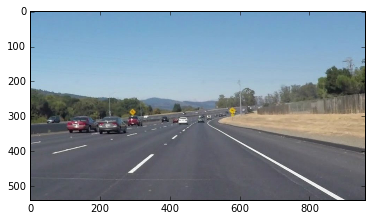

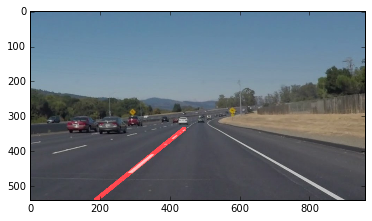

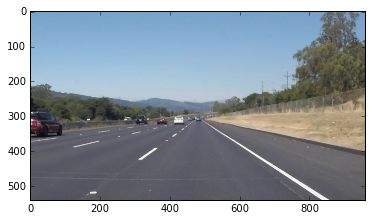

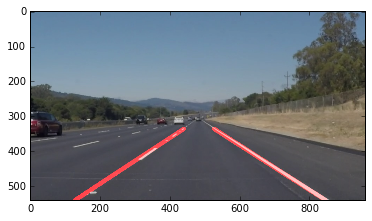

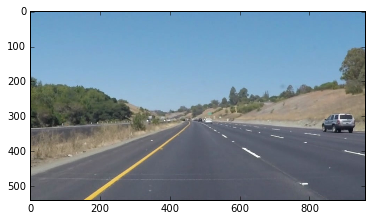

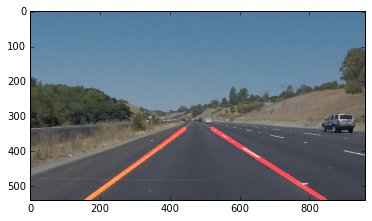

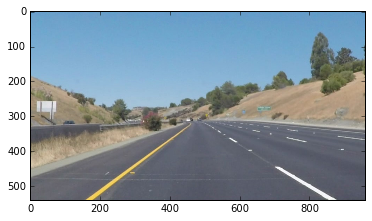

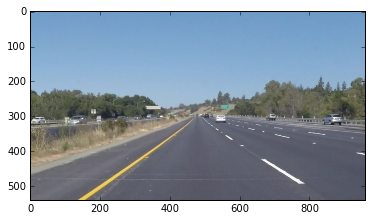

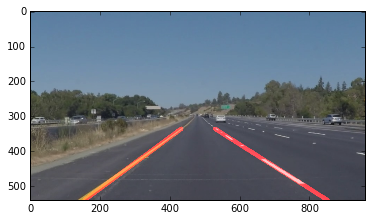

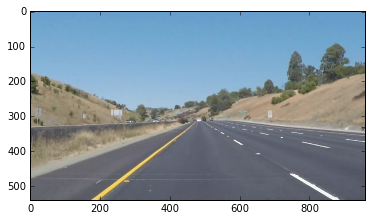

In [179]:
for image in ['solidWhiteCurve.jpg','solidWhiteRight.jpg','solidYellowCurve.jpg',
              'solidYellowCurve2.jpg','solidYellowLeft.jpg','whiteCarLaneSwitch.jpg']: #['whiteCarLaneSwitch.jpg']: #
    image_url = "test_images/" +image
    #print(image_url)
    img = (mpimg.imread(image_url))
    plt.figure()
    plt.imshow(img)

    image_lines =  pilpeline_draw_lane_lines(img)
    plt.figure()
    plt.imshow(image_lines)
    plt.savefig("test_images/output_"+image)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [180]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [181]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = pilpeline_draw_lane_lines(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [182]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████████████████████████████████████████████▊| 221/222 [00:08<00:00, 22.20it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 9.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [183]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [184]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████████████████████████████████████████████▉| 681/682 [00:33<00:00, 20.55it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 34.5 s


In [185]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


With the initial and basic pipeline, composed by grayscaling, gaussian smoothing, canny edge detection, masking and Hough transform line detection
We get for first two videos clear drawn lines, following each lane line.
The main idea to get these final lines for each lane line is averaging both: slopes and x-axis intercepts for lines obtained from the Hough transformation. With an average x-axis intercept, an average slope and a calculated intersection with the top end considered in the horizon, we obtain the final segment for each line.

Problems detected with that first approach:
- Differences between continuous yellow line and white discontinuous one. In some sections, last one seems more unstable.
A part from that, that first and basic approach has some other weakness that would need to be fixed in order to be useful for other kind of roads. Some of them can be observed with the third video:
- How to deal with are curvy lanes?
- How to deal with many noisy lines detected in the road, for example due to changes in shadows or illumination?

In order to reduce both effects, I have implemented two kind of adjustments:
1. Basic slope filters in order to avoid horizontal or other noisy lines (detected for changes on lights or even the hood of the car)
2. Added cluster classification of Hough lines, with k-means, when different groups of lines were detected, selecting the most appropiate group, and ignoring those considered as noisy.
The way to decide when to apply clustering filters has been:
For each of both groups of right lane lines and left lane lines, we calculate the average and standard deviation for all the x-axis intercept for each line of the group. If the standard deviation normalized by x size of the image is higher than a certain coefficient of variation, we consider that there is more noise (at least, variation) than expected, and we proceed to select the most relevant lines.
For that, k-means of clustering 2 is implemented, with variables x-axis intercept and length  of the segment detected, and lines are classified in 2 groups. The selection criteria for the "good" group can vary:
I have tryed with that containing the longest Hough lines, or the one for which the average length is higher, that's what I have chosen finally.
The main limitation of that method is that for the nature of the variables chosen, it doesn't help to separate those lines with similar length, similar x-interception but different slope, that obviously can't be both in the same lane line.
But even with current limitations, I have been able to reduce lot of noise obtained with the basic pipeline for the third video.

Other approaches could help to obtain better results like:
- Improving in shadow and illumination correction with filters (I guess that's possible although not sure how to do that, yet)
- Better detection for different color lane lines (same comment)
- Deeper slope selection for curve lines, and not just adding some thresholds
- Improving selection criteria for clustering k-means (if there is a clear main line, or if taking averages as i have done here...)
- improving clustering algorith (maybe just adding slopes as a feature), in order to avoid limitation described above.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extrau.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

-0.62676056338
-0.642857142857
0.574074074074
-0.7
-0.625
0.625
-0.692307692308
-0.686274509804
-0.741935483871
0.623655913978
-0.52
-0.76
0.571428571429
-0.769230769231
-0.607142857143
-0.48
-0.0363636363636
-0.689655172414
0.585365853659
-0.205882352941
-0.05
-0.892857142857
-0.661971830986
-0.766666666667
0.0
-0.05
-0.632653061224
0.0
-0.470588235294
-0.478260869565
-0.870967741935
[MoviePy] >>>> Building video extrau.mp4
[MoviePy] Writing video extrau.mp4


  0%|▏                                                   | 1/251 [00:00<00:32,  7.66it/s]

-0.62676056338
-0.642857142857
0.574074074074
-0.7
-0.625
0.625
-0.692307692308
-0.686274509804
-0.741935483871
0.623655913978
-0.52
-0.76
0.571428571429
-0.769230769231
-0.607142857143
-0.48
-0.0363636363636
-0.689655172414
0.585365853659
-0.205882352941
-0.05
-0.892857142857
-0.661971830986
-0.766666666667
0.0
-0.05
-0.632653061224
0.0
-0.470588235294
-0.478260869565
-0.870967741935
-0.672727272727

  1%|▍                                                   | 2/251 [00:00<00:32,  7.72it/s]


-0.700483091787
-0.52
-0.703125
0.571428571429
0.55223880597
-0.5
0.603448275862
-0.516666666667
-0.52
0.0666666666667
-0.684210526316
-0.555555555556
-0.5
-0.689655172414
-0.660714285714
0.55
-0.55
-0.733333333333
0.0
0.0
-0.666666666667
-0.857142857143
0.0
-0.636363636364
-0.666666666667
-0.653846153846
-0.695652173913
-0.6875
-0.142857142857
-0.92
0.0
-0.701421800948

  1%|▌                                                   | 3/251 [00:00<00:34,  7.27it/s]


-0.649746192893
-0.705128205128
-0.652173913043
-0.651162790698
0.681818181818
-0.711538461538
0.0689655172414
-0.5
-1.0
0.185185185185
-0.0952380952381
0.6
-0.772727272727
0.571428571429
-0.793103448276
-0.65
-0.964285714286
0.0
-1.0
-0.612903225806
-0.769230769231
-0.608695652174
-0.636363636364
0.619047619048
-0.651583710407

  2%|▊                                                   | 4/251 [00:00<00:33,  7.33it/s]


-0.702127659574
-0.694915254237
-0.66
-0.764705882353
0.739130434783
-0.740740740741
0.625
-0.772727272727
-0.68
-0.695652173913
-0.75
-0.65625
0.0384615384615
0.612903225806
-0.645161290323
-0.714285714286
-0.701244813278
-0.649789029536
-0.736842105263
0.586206896552
-0.727272727273
0.605263157895
-0.730769230769
-0.68
-0.636363636364
0.615384615385
-0.833333333333
0.583333333333
0.0869565217391
-0.740740740741
-0.774193548387
-0.6875
-0.637931034483
-0.541666666667
-0.619047619048
-0.740740740741
-0.636363636364
-0.695652173913
-0.708333333333
-0.363636363636
-0.65
-0.65625
-0.701863354037

  2%|█▏                                                  | 6/251 [00:00<00:30,  8.11it/s]


-0.666666666667
-0.690476190476
-0.7
0.636363636364
-0.625
-0.723404255319
0.681818181818
-0.774193548387
-0.75
0.619047619048
0.571428571429
0.625
-0.621621621622
-0.702702702703
0.0
0.0
-0.0434782608696
-0.638888888889
-0.722222222222
-0.722222222222
-0.735294117647
-0.363636363636
-0.666666666667
-0.363636363636
-0.681818181818
-0.358974358974
-0.714285714286
-0.142857142857
-0.666666666667
-0.673553719008
-0.722222222222
-0.677419354839
-0.78125
0.615384615385
0.6
-0.723404255319
-0.703703703704
-0.721088435374
-0.688888888889
0.645833333333
-0.473684210526
0.0
-1.0303030303
0.606060606061
-1.11111111111
0.0
0.0
-0.703703703704
-0.6875
0.708333333333
-0.125
0.0
-1.03448275862
0.0
0.64
-0.696551724138

  3%|█▋                                                  | 8/251 [00:00<00:27,  8.78it/s]


-0.673076923077
-0.706896551724
-0.615384615385
0.65
0.64406779661
-0.69387755102
-0.708333333333
-0.585365853659
-1.0
-0.708333333333
-0.6
-0.809523809524
0.047619047619
-1.06451612903
-0.434782608696
-0.125
0.655172413793
-0.538461538462
-0.65
-0.047619047619
-0.814814814815
-0.766666666667
0.0
-0.818181818182
-0.730769230769
0.046511627907
-0.674033149171
-0.723404255319
-0.726618705036
0.58024691358
0.650793650794
-0.717948717949
-0.0487804878049
-0.0689655172414
-0.15
-0.717391304348
0.555555555556
0.643835616438
-0.717391304348
-0.733333333333
0.585365853659
0.142857142857
-0.380952380952
0.0535714285714
-0.621621621622
-0.700934579439

  4%|██                                                 | 10/251 [00:01<00:24,  9.86it/s]


-0.748201438849
-0.689189189189
0.623655913978
-0.742424242424
0.618556701031
-0.714285714286
-0.685714285714
-0.727272727273
-0.777777777778
-0.761904761905
-0.5
0.628571428571
-0.25
-0.25
0.0
0.612903225806
-0.0322580645161
0.62
-0.48275862069
-0.826086956522
-0.744186046512
-0.428571428571
-0.434782608696
-0.675
-0.761904761905
0.621621621622
-0.681818181818
-0.72972972973
0.620967741935
0.616161616162
-0.739130434783
-0.666666666667
-0.647058823529
-0.627118644068
-0.655172413793
0.616666666667
0.0
-0.758620689655
-0.8
-0.727272727273
-0.7
-0.272727272727
0.601769911504
-0.285714285714
0.0555555555556
-0.3
-0.636363636364
-0.272727272727
-0.685714285714
0.63768115942
-0.62962962963
-0.666666666667
-0.655737704918

  5%|██▍                                                | 12/251 [00:01<00:22, 10.52it/s]


0.576923076923
-0.695364238411
0.626016260163
-0.752688172043
-0.767441860465
-0.720930232558
0.555555555556
0.622950819672
-0.909090909091
-0.68
0.0754716981132
-0.192307692308
-0.173913043478
-0.8
-0.307692307692
-0.208333333333
-0.75
0.05
-0.5
-0.75
-0.710526315789
0.05
-0.272727272727
-0.15
-0.699074074074
0.514285714286
0.56
-0.767441860465
-0.728571428571
-0.676829268293
0.59375
0.622222222222
-0.673913043478
-0.722222222222
-0.714285714286
0.591836734694
-0.80487804878
-0.8
-0.71875
-0.75
-0.8
-0.732142857143
-0.772727272727
-0.689655172414
-0.666666666667
0.633333333333
-0.7
-0.761904761905
0.6
-0.782608695652
-0.565217391304
0.0416666666667
-0.333333333333
-0.24
-0.692307692308
-0.84
-0.714285714286
-0.208333333333
-0.75

  6%|██▊                                                | 14/251 [00:01<00:20, 11.35it/s]


-0.698347107438
0.552631578947
-0.870967741935
0.625
-0.839285714286
-0.833333333333
0.619047619048
-0.846153846154
-0.571428571429
-0.814814814815
-0.571428571429
-0.846153846154
-0.7
-0.777777777778
0.540540540541
-0.8
-0.703703703704
0.466666666667
-0.818181818182
0.615384615385
-0.793103448276
-0.725
-0.571428571429
-0.755102040816
-0.85
-0.751243781095
-0.699570815451
-0.701492537313
0.571428571429
-0.840909090909
0.583333333333
-0.74
-0.785714285714
-0.433333333333
-0.416666666667
0.533333333333
-0.8
-0.810810810811
-0.655913978495
-0.716666666667
-0.752380952381

  6%|███▎                                               | 16/251 [00:01<00:19, 12.17it/s]


-0.700787401575
-0.702702702703
0.636363636364
0.666666666667
-0.821428571429
-0.709677419355
0.625
-0.735294117647
-0.793103448276
-0.4375
-0.807692307692
-0.8
-0.78125
-0.821428571429
-0.777777777778
-0.7
0.2
-0.730769230769
-0.766666666667
-0.05
-0.752336448598
-0.700854700855
0.605263157895
0.594594594595
-0.703296703297
-0.754545454545
-0.701030927835
-0.777777777778
-0.745098039216
0.607142857143
-0.428571428571
0.560975609756
-0.821428571429
-0.753086419753

  7%|███▋                                               | 18/251 [00:01<00:17, 13.24it/s]


-0.702702702703
-0.709677419355
-0.688888888889
-0.745098039216
0.641025641026
-0.625
-0.692307692308
0.6
-0.539682539683
0.588235294118
-0.673469387755
0.0
-0.0384615384615
-0.681818181818
-0.740740740741
-0.772727272727
0.611111111111
-0.724137931034
0.227272727273
-0.710144927536
-0.8125
-0.75
-0.714285714286
-0.776119402985
-0.676056338028
-0.688888888889
-0.650793650794
0.605263157895
-0.666666666667
0.561403508772
-0.653846153846
0.578947368421
-0.692307692308
0.0
-0.652173913043
0.592592592593
-0.653846153846
-0.674418604651
0.0
-0.173913043478
-0.56
0.55
-0.764705882353
-0.782608695652
-0.709677419355
0.0
-0.7

  8%|████                                               | 20/251 [00:01<00:16, 14.13it/s]


-0.727272727273
-0.741379310345
-0.691176470588
0.567164179104
0.64406779661
-0.739130434783
-0.7
-0.717391304348
-0.458333333333
0.568181818182
0.684210526316
-0.701754385965
-0.733333333333
-0.733333333333
-0.739130434783
0.0869565217391
0.0
-0.75
-0.653846153846
0.604166666667
-0.753138075314
-0.7
0.590361445783
0.644736842105
-0.676470588235
-0.752688172043
-0.76
0.666666666667
-0.45652173913
-0.666666666667
0.593220338983
-0.7
-0.733333333333
-0.666666666667
-0.15
-0.7
2.33333333333
0.64
-0.0344827586207
-0.710526315789
2.15384615385
2.45454545455
-0.700421940928

  9%|████▋                                              | 23/251 [00:01<00:14, 15.96it/s]


-0.751219512195
0.5625
0.626262626263
0.545454545455
-0.491525423729
-0.700598802395
0.551724137931
-0.772727272727
0.645161290323
-0.793103448276
-0.952380952381
0.0
0.0
-0.488888888889
-0.310344827586
0.614035087719
-0.703703703704
-0.753846153846
-0.700483091787
0.601941747573
0.592233009709
0.586206896552
-0.467741935484
0.612903225806
-0.686274509804
-0.768115942029
-0.760869565217
-0.0294117647059
0.0285714285714
0.64
-0.727272727273
-0.757575757576
0.625
-0.333333333333
0.0
0.296296296296
-0.333333333333
-0.708333333333
-0.318181818182
-0.3
0.518518518519
0.619834710744
-0.75
-0.753086419753
-0.701492537313
0.576923076923
-0.718446601942
-0.782608695652
0.618181818182
-0.671641791045
-0.6
-0.7
-0.789473684211
0.617647058824
-0.678571428571
0.642857142857
-0.739130434783
-0.53488372093
-0.785714285714
-0.0697674418605
-0.5
-0.652173913043
0.555555555556
-0.0425531914894
-0.666666666667
-0.5
-0.433333333333
-0.479166666667
-0.0444444444444
0.564102564103
-0.0344827586207
-0.03448

 10%|█████                                              | 25/251 [00:01<00:13, 16.32it/s]


-0.697872340426
0.557894736842
-0.753191489362
0.611111111111
-0.701149425287
0.025
-0.0322580645161
-0.518518518519
-0.5
0.6
0.55
-0.909090909091
-0.702127659574
-0.785714285714
0.535714285714
0.625
-0.093023255814
-0.380952380952
-0.15
-0.0357142857143
-0.15
-0.776223776224
-0.724832214765
-0.53125
-0.573529411765
-0.6
0.625
0.541666666667
-0.739130434783
-0.787878787879
-0.785714285714
-0.516129032258
0.652173913043
0.652173913043
-0.56
-0.574468085106
-0.509090909091
-0.809523809524
-0.741379310345
-0.710526315789
-0.56
-0.753246753247

 11%|█████▍                                             | 27/251 [00:02<00:12, 17.23it/s]


-0.701149425287
-0.6875
-0.727272727273
-0.739130434783
-0.527777777778
-0.557692307692
-0.688888888889
0.653846153846
-0.652173913043
0.615384615385
-0.716049382716
-0.733333333333
-0.666666666667
-0.701754385965
-0.375
-0.323529411765
-0.325
-0.620689655172
-0.678571428571
-0.700483091787
-0.761363636364
-0.729166666667
-0.705128205128
-0.727272727273
0.645161290323
-0.467741935484
-0.736842105263
0.612903225806
-0.740740740741
-0.7
-0.47619047619
-0.481481481481
0.6875
0.58064516129
-0.36
-0.448275862069
-0.615384615385
-0.6875
0.583333333333
-0.772727272727
-0.304347826087
-0.551020408163
-0.318181818182
-0.701492537313

 12%|█████▉                                             | 29/251 [00:02<00:12, 17.55it/s]


-0.745098039216
-0.764705882353
-0.776785714286
-0.506493506494
-0.790697674419
0.657142857143
0.6
-0.557692307692
-0.702898550725
-0.806451612903
0.621621621622
-0.407407407407
-0.55
-0.703703703704
0.05
-0.05
-0.808510638298
0.583333333333
-1.12
-0.736842105263
-0.736263736264
-0.699507389163
-0.7
-0.701492537313
0.620689655172
-0.514285714286
-0.7
0.617021276596
-0.434782608696
0.659090909091
-0.896551724138
-0.71875
-0.410256410256
0.613636363636
-0.68
-0.025641025641
-0.0416666666667
-0.701754385965
-0.047619047619
-0.8
-0.423076923077
-0.75
-0.407407407407
0.0
0.608695652174
-0.470588235294
-0.0434782608696
0.0
-0.4375
-0.751552795031

 12%|██████▎                                            | 31/251 [00:02<00:13, 16.55it/s]


-0.675496688742
0.66
-0.686567164179
0.615384615385
-0.80701754386
-0.583333333333
-0.727272727273
-0.782608695652
-0.833333333333
-0.766666666667
-0.85
-0.16
-0.444444444444
-0.747474747475
0.611111111111
0.653846153846
-0.675675675676
-0.65
-0.833333333333
-0.719512195122
0.0238095238095
-0.8
-0.442307692308
-0.0344827586207
0.0222222222222
-0.701863354037
-0.696629213483
-0.769230769231
0.666666666667
0.623188405797
-0.571428571429
-0.789473684211
-0.861111111111
-0.559322033898
-0.685714285714
0.655172413793
-0.705882352941
0.0
0.65
0.6875
-0.695652173913
-0.751724137931
0.597014925373
0.0344827586207
-0.74
-0.68
-0.538461538462
0.676470588235
-0.700534759358

 13%|██████▋                                            | 33/251 [00:02<00:13, 16.24it/s]


-0.686567164179
-0.6
0.579545454545
-0.7
-0.649484536082
0.606060606061
-0.649253731343
-0.689655172414
-0.666666666667
-0.717391304348
0.571428571429
0.603174603175
0.571428571429
-0.620253164557
-0.673913043478
-0.761904761905
0.555555555556
0.545454545455
0.566666666667
-0.619047619048
0.6
-0.75
0.63768115942
-0.64
-0.648936170213
0.575221238938
-0.686274509804
-0.718446601942
0.68
-0.702702702703
-0.727272727273
-0.8
0.692307692308
-0.739130434783
-0.733333333333
-0.76
-0.756756756757
-0.659090909091
-0.761904761905
0.0
0.486486486486
-0.791666666667
-0.8
-0.469387755102
0.626506024096
0.59375
-0.692307692308
0.581395348837
-0.772727272727
-0.666666666667
-0.694444444444
-0.761904761905
0.217391304348
-0.724137931034
-0.791666666667
-0.700854700855

 14%|███████                                            | 35/251 [00:02<00:13, 15.82it/s]


0.623188405797
-0.674311926606
0.594405594406
-0.793103448276
-0.841463414634
-0.683544303797
-0.6875
-0.787878787879
-0.672131147541
-0.692307692308
-0.730769230769
-0.791666666667
-0.72619047619
-0.724137931034
-0.678571428571
0.610169491525
-0.484848484848
-0.333333333333
0.622807017544
0.0
-0.5
0.592592592593
-0.862068965517
-0.846153846154
-0.869565217391
0.0
0.0
-0.825
-0.571428571429
-0.65
-0.862068965517
-0.631578947368
-0.464285714286
-0.878787878788
0.0
0.58064516129
0.625
-0.71875
0.594827586207
-0.741379310345
-0.674418604651
-0.492063492063
-0.8
-0.806451612903
-0.688888888889
-0.742857142857
-0.666666666667
0.627906976744
-0.526315789474
-0.636363636364
0.6
-0.142857142857
-0.714285714286
-0.730337078652
-0.459016393443
-0.0243902439024
0.64
-0.62962962963
-0.757575757576
-0.15
-0.6875
0.55
-0.133333333333
-0.46875
-0.208333333333
-0.833333333333
-0.125
0.621621621622
0.6
-1.09523809524
-0.454545454545
-0.68
-0.030303030303
-0.238095238095
-0.147058823529
-0.238095238095

 15%|███████▌                                           | 37/251 [00:02<00:12, 16.54it/s]


-0.673076923077
-0.704225352113
0.636363636364
0.677966101695
0.594936708861
-0.52380952381
-0.8
-0.823529411765
-0.432432432432
-0.85
-0.861111111111
-0.674157303371
-0.388888888889
0.655172413793
-0.827586206897
-0.857142857143
-0.717391304348
-0.666666666667
-0.71875
-0.771428571429
-0.844444444444
-0.823529411765
-0.783783783784
0.65
-0.545454545455
-0.6
-0.75
-0.52
-0.794117647059
-0.961538461538
0.554054054054
-0.871794871795
-0.95
0.677419354839
-0.745098039216
-0.623931623932
-0.603448275862
-0.647058823529
-0.693333333333
-0.772727272727
0.6
0.592592592593
-0.75
0.6
-0.666666666667
-0.658536585366
0.7
-0.6625
-0.692307692308
0.566666666667
-0.818181818182
0.634146341463
0.0
-0.727272727273
-0.772727272727
-0.75
0.0
-0.722891566265

 16%|███████▉                                           | 39/251 [00:02<00:12, 16.98it/s]


-0.674418604651
-0.636363636364
-0.571428571429
-0.702702702703
-0.661290322581
0.607142857143
-0.717948717949
-0.744680851064
0.6
-0.5
-0.03125
0.0735294117647
0.6
-0.464285714286
-0.688524590164
-0.47619047619
-0.607476635514
0.0454545454545
-0.0869565217391
0.625
0.0789473684211
-0.722222222222
-0.709677419355
-0.130434782609
-0.047619047619
-0.391304347826
-0.625
-0.724137931034
-0.649717514124
-0.645161290323
-0.705882352941
-0.650485436893
-0.541666666667
0.588235294118
-0.515151515152
0.617647058824
-0.657142857143
-0.6875
-0.730769230769
0.636363636364
-0.767441860465
-0.685185185185
-0.714285714286
0.588235294118
0.0512820512821
-0.647058823529
-0.620689655172
-0.931034482759
-0.95652173913
-0.615384615385
-0.658823529412

 17%|████████▌                                          | 42/251 [00:02<00:11, 17.71it/s]


-0.699507389163
-0.624309392265
0.615384615385
-0.690909090909
0.6
-0.730769230769
-0.624
-0.6875
-0.676470588235
-0.666666666667
-0.0952380952381
-0.636363636364
-0.0454545454545
-0.709677419355
0.59375
0.227272727273
-0.047619047619
-0.619047619048
-0.625
-0.625
0.0
-0.652173913043
-0.689655172414
-0.700534759358
-0.648351648352
-0.65
-0.685714285714
0.666666666667
-0.457142857143
0.617021276596
-0.45
-0.691358024691
0.625
-0.130434782609
-0.666666666667
-0.428571428571
0.68
-0.666666666667
-0.826086956522
-0.4375
-0.65
-0.681818181818
-0.772727272727
0.0322580645161
0.0
-0.666666666667
-0.826086956522
-0.699507389163
-0.642857142857
-0.628205128205
-0.661971830986
-0.692307692308
0.6
-0.688888888889
-0.695652173913
-0.727272727273
0.618181818182
0.603448275862
-0.75
-0.7
-0.791666666667
-0.736842105263
-0.714285714286
-0.791666666667
0.6
-0.662162162162
-1.41176470588
-0.791666666667
-0.765957446809
-0.68
0.0
0.0
-0.697872340426

 18%|████████▉                                          | 44/251 [00:03<00:11, 17.73it/s]


-0.648888888889
0.591549295775
0.638888888889
0.623188405797
-0.7
-0.615384615385
-0.666666666667
-0.814814814815
-0.727272727273
-0.666666666667
-0.757575757576
0.6
-0.63829787234
-0.0322580645161
-0.48
-0.65034965035
-0.6875
-0.688888888889
-0.699530516432
-0.649350649351
0.569892473118
-0.692307692308
-0.785714285714
0.613636363636
-0.651851851852
-0.473684210526
-0.727272727273
-0.772727272727
-0.711111111111
-0.684931506849
-0.478260869565
0.0
-0.686567164179
0.692307692308
-0.452380952381
-0.75
-0.652173913043
-0.649122807018
0.555555555556
0.576923076923
0.652173913043
-0.703448275862

 18%|█████████▎                                         | 46/251 [00:03<00:11, 17.81it/s]


-0.671171171171
0.578512396694
0.6
-0.679245283019
-0.688524590164
-0.568181818182
-0.68
-0.666666666667
-0.702702702703
-0.769230769231
0.586206896552
0.589285714286
-0.833333333333
-0.636363636364
0.563636363636
0.0
-0.507042253521
-0.472222222222
0.047619047619
-0.833333333333
-0.681818181818
-0.711538461538
-0.666666666667
-0.464285714286
-0.85
0.613333333333
0.642857142857
-0.695652173913
-0.724137931034
0.598540145985
-0.671497584541
0.571428571429
-0.672131147541
-0.715909090909
-0.413043478261
-0.8
-0.739130434783
0.0277777777778
-0.75
-0.772727272727
0.583333333333
0.564102564103
-0.736842105263
-0.682926829268
-0.8
0.604651162791
0.608695652174
0.567567567568
-0.491803278689
0.0
-0.538461538462
-0.756756756757
-0.660377358491

 19%|█████████▊                                         | 48/251 [00:03<00:13, 15.00it/s]


-0.706422018349
-0.657534246575
0.572727272727
-0.677419354839
0.613333333333
-0.707547169811
-0.688888888889
-0.608695652174
-0.708333333333
-0.6
0.68
-0.615384615385
-0.642857142857
-0.666666666667
-0.777777777778
0.58064516129
0.636363636364
0.567164179104
-0.647058823529
-0.761904761905
0.655172413793
-0.454545454545
-0.227272727273
-0.227272727273
0.634146341463
-0.65
-0.652777777778
-0.674796747967
-0.719512195122
0.630769230769
-0.709677419355
-0.673611111111
0.554054054054
-0.69387755102
-0.677419354839
-0.666666666667
-0.707317073171
-0.410256410256
0.547945205479
-0.40625
-0.653846153846
0.608695652174
0.642857142857
-0.6
-0.6
-0.678571428571
-0.666666666667
-0.777777777778
-0.413043478261
-0.69696969697
-0.68085106383
0.63829787234
-0.725581395349

 20%|██████████▏                                        | 50/251 [00:03<00:13, 14.76it/s]


-0.674311926606
-0.725
-0.828571428571
-0.675862068966
0.615384615385
-0.8
0.666666666667
-0.818181818182
-0.735294117647
-0.724137931034
-0.657894736842
0.52380952381
-0.764705882353
-0.45
0.380952380952
-0.857142857143
-0.828571428571
-0.9
0.590909090909
-0.726744186047
-0.682242990654
-0.657894736842
-0.72
-0.650485436893
-0.675
-0.833333333333
0.666666666667
-0.810810810811
0.6
-0.8
-0.681818181818
0.666666666667
-0.395348837209
-0.716981132075
-0.809523809524
-0.761904761905
-0.716981132075
-0.746835443038
0.58064516129
-0.790697674419
-0.62962962963
0.6
-0.447368421053
-0.0571428571429
-0.8
-0.772727272727
-0.727272727273

 21%|██████████▌                                        | 52/251 [00:03<00:14, 14.19it/s]


-0.674698795181
-0.675159235669
0.611111111111
-0.810810810811
0.65625
-0.848484848485
-0.722222222222
-0.555555555556
0.03125
-0.1
-0.84
-0.838709677419
-0.652173913043
0.217391304348
-0.677419354839
0.190476190476
-0.84375
-0.814814814815
0.52
-0.678787878788
-0.725806451613
-0.651376146789
0.625
0.6
-0.681818181818
-0.5
0.6
-0.526315789474
-0.76
-0.742424242424
-0.0909090909091
-0.68
0.615384615385
-0.704918032787
-0.566666666667
-0.0952380952381
-0.666666666667
0.2
-0.0909090909091
-0.5
-0.673758865248
-0.714285714286
-0.85
-0.724696356275

 22%|██████████▉                                        | 54/251 [00:03<00:14, 13.42it/s]


-0.695035460993
0.595744680851
-0.697368421053
-0.75
-0.5
0.6
0.64
-0.0769230769231
-0.509803921569
-0.7
-0.727272727273
-0.5
-0.896551724138
0.58
0.0
0.0869565217391
0.619047619048
0.0
-0.45
-0.727272727273
-0.711111111111
-0.40625
-0.446808510638
-0.698412698413
-0.748091603053
-0.576923076923
-0.558823529412
0.616666666667
-0.785714285714
0.610169491525
-0.78125
-0.866666666667
-0.571428571429
-0.78125
-0.764705882353
-0.564102564103
0.606060606061
-0.545454545455
0.0
-0.558139534884
0.608695652174
-0.708333333333
0.625
-0.870967741935
-0.692307692308
0.0
-0.727272727273
-0.698113207547

 22%|███████████▍                                       | 56/251 [00:03<00:14, 13.23it/s]


-0.726368159204
0.621621621622
-0.471428571429
0.552631578947
-0.69696969697
-0.444444444444
-0.703703703704
-0.726495726496
-0.6875
-0.716981132075
0.533333333333
-0.733333333333
0.565217391304
-0.710526315789
0.642857142857
-0.710526315789
-0.461538461538
-0.478260869565
0.0
-0.130434782609
-0.125
-0.698564593301
-0.729032258065
-0.74
0.59595959596
0.602150537634
-0.511627906977
-0.463414634146
0.0
0.652173913043
0.0196078431373
-0.681818181818
-0.7
-0.413793103448
-0.851851851852
0.611111111111
-0.695652173913
0.613636363636
-0.433333333333
-0.47619047619
-0.685714285714
-0.9
-0.725
0.535714285714
0.6
-0.5
0.0
-0.742424242424

 23%|███████████▊                                       | 58/251 [00:04<00:16, 11.42it/s]


-0.701149425287
0.623931623932
-0.78125
-0.794871794872
0.582417582418
-0.581081081081
-0.794117647059
-0.527272727273
0.554054054054
0.558823529412
-0.714285714286
0.636363636364
-0.461538461538
-0.807692307692
-1.02222222222
-0.75
0.606060606061
-0.56
-0.651162790698
0.54347826087
-0.676470588235
-0.535714285714
-1.04761904762
-0.75
-0.666666666667
-0.8
-0.478260869565
-0.171428571429
0.0344827586207
0.558139534884
-0.648936170213
-0.698979591837
-0.75
0.603305785124
0.59375
-0.700636942675
-0.597014925373
0.598360655738
0.0416666666667
0.585365853659
-0.752873563218
0.607142857143
0.575
0.610169491525
-0.47619047619
-0.561403508772
-0.675675675676
0.64406779661
0.0344827586207
-0.464285714286
-0.48
-0.696808510638

 24%|████████████▏                                      | 60/251 [00:04<00:17, 11.04it/s]


-0.75
0.59595959596
-0.677419354839
0.633333333333
0.657142857143
-0.515151515152
-0.698224852071
-0.585365853659
0.62962962963
-0.56862745098
-0.52380952381
0.65
0.521739130435
-0.535714285714
-0.741379310345
0.5
-0.481481481481
0.65
0.0
0.0444444444444
-0.541666666667
0.0
0.6
0.666666666667
-0.726618705036
-0.681818181818
-0.624
0.647058823529
-0.6
0.573170731707
0.571428571429
0.0877192982456
-0.653846153846
-0.695652173913
-0.65
0.584905660377
-0.590909090909
0.961538461538
-0.821428571429
-0.76
0.111111111111
-0.55
0.0
-0.75
-0.148148148148
-0.794117647059
-0.15625
0.636363636364
-0.2
-0.548387096774
-0.225
-0.64
-0.166666666667
0.0
-0.738095238095
-0.72619047619
-0.717948717949
0.136363636364
-0.7265625

 25%|████████████▌                                      | 62/251 [00:04<00:18, 10.11it/s]


-0.8
-0.716417910448
-0.825396825397
-0.635135135135
-0.721518987342
-0.694444444444
-0.647058823529
-0.602040816327
-0.692307692308
0.64
-0.804347826087
-0.84
-0.741935483871
-0.578947368421
0.653846153846
-0.666666666667
-0.606060606061
-0.130434782609
-0.8
-0.95652173913
0.64
-0.581395348837
-0.130434782609
-0.794117647059
-0.75
-0.8125
-0.75
-0.730769230769
-0.518518518519
0.0909090909091
-0.695652173913
-0.075
-0.72
-0.723756906077
-0.682926829268
-0.660714285714
-0.83950617284
-0.575757575758
-0.72602739726
-0.624060150376
-0.833333333333
-0.608695652174
-0.607142857143
-0.819444444444
0.606060606061
0.612903225806
-0.858974358974
-0.818181818182
-0.85
-0.9
-0.642857142857
-0.806451612903
0.025
-0.818181818182
0.0
0.535714285714
-0.761904761905
0.68
0.08
-0.666666666667
-0.65

 25%|█████████████                                      | 64/251 [00:04<00:18, 10.09it/s]


-0.693548387097
-0.636363636364
0.0121951219512
-0.84375
-0.736842105263
0.678571428571
-0.75
0.628571428571
-0.807692307692
-0.636363636364
-0.648
-0.794117647059
-0.657894736842
0.675675675676
0.621621621622
-0.818181818182
-0.705882352941
-0.676470588235
-0.647058823529
0.0
-0.382352941176
0.0
-0.678571428571
-0.8
0.0
-0.740740740741
-0.745098039216
-0.722222222222
-0.68
-0.769230769231
-0.05
-0.649717514124
-0.702898550725
-0.692307692308
-0.688888888889
0.613636363636
0.574468085106
-0.619047619048
-0.717391304348
-0.972222222222
-0.714285714286
-0.685185185185
-0.75
-0.816326530612
-0.785714285714
-0.666666666667
-0.761904761905
0.576923076923
-0.795918367347
-0.6875
0.0
-0.727272727273
-0.492957746479
0.0
-1.0
-0.761904761905
-0.818181818182
-0.772727272727
-0.851851851852
0.620689655172
0.0833333333333
-0.75
-1.25
-0.67

 26%|█████████████▍                                     | 66/251 [00:05<00:19,  9.59it/s]


-0.7004048583
0.6
-0.666666666667
0.6
-0.730769230769
-0.703703703704
-0.6875
-0.701986754967
0.595744680851
-0.46
-0.820512820513
-0.779661016949
0.584905660377
-0.8
0.0
0.0
0.0
-0.414634146341
-0.75
0.0
-0.808510638298
-0.65
-0.678571428571
-0.818181818182
-0.708333333333
-0.428571428571
0.0
0.0
-0.704142011834

 27%|█████████████▌                                     | 67/251 [00:05<00:19,  9.67it/s]


-0.673366834171
-0.648351648352
-0.670886075949
0.582089552239
0.64406779661
-0.5
-0.54347826087
-0.677419354839
0.595744680851
-0.75
-0.727272727273
0.0
-0.65
0.0
-0.735294117647
0.627118644068
-0.761904761905
-0.666666666667
0.0
-0.722772277228

 27%|█████████████▊                                     | 68/251 [00:05<00:19,  9.35it/s]


-0.672268907563
0.59756097561
0.615384615385
-0.738095238095
-0.473684210526
0.0
-0.75
-0.720588235294
-0.818181818182
-0.8
-0.30303030303
-0.129032258065
0.625
-0.9
-0.685185185185
-0.375
-0.647058823529
0.612903225806
-0.75
0.0
-0.2
-0.661971830986
-0.88
-0.772727272727
-0.723618090452
-0.673640167364
0.579439252336
0.623762376238
-0.674698795181
-0.393939393939
-0.739130434783
0.545454545455
-0.477272727273
-0.8
0.598039215686
0.0
-0.47619047619
0.602040816327
-0.592592592593
-0.647727272727
-0.0333333333333
0.0
-0.761904761905
-0.457142857143
-0.726368159204

 28%|██████████████▏                                    | 70/251 [00:05<00:18,  9.56it/s]


-0.675324675325
0.621212121212
0.578571428571
-0.584615384615
-0.673469387755
-0.875
-0.483870967742
0.0
0.577981651376
0.617647058824
-0.48275862069
-0.451612903226
0.0
0.642857142857
0.63829787234
-0.652173913043
-0.913043478261
-0.636363636364
-0.714285714286
0.527777777778
0.0
-0.649484536082
0.60162601626

 28%|██████████████▍                                    | 71/251 [00:05<00:20,  8.93it/s]


-0.725806451613
-0.674418604651
0.560975609756
-0.722222222222
-0.68
0.552631578947
-0.55
-0.75
0.545454545455
-0.0869565217391
-0.66
-0.728395061728
-0.5
-0.740740740741
-0.652173913043
0.628571428571
0.0
0.0
0.595041322314
-0.68
0.142857142857
-0.672727272727
-0.0416666666667
-0.645161290323
-0.407407407407
0.550561797753
-0.75

 29%|██████████████▋                                    | 72/251 [00:05<00:20,  8.80it/s]


-0.69587628866
0.571428571429
0.571428571429
-0.741935483871
-0.5
-0.533333333333
-0.76
-0.551724137931
-0.527777777778
0.0
-0.888888888889
0.578947368421
-0.699421965318
-0.487804878049
0.551020408163
-0.472727272727
-0.190476190476
-0.75
-0.766666666667
-0.472727272727
0.571428571429
-0.700598802395

 29%|██████████████▊                                    | 73/251 [00:05<00:22,  7.79it/s]


-0.726495726496
-0.51724137931
-0.681818181818
0.542372881356
-0.737704918033
-0.541666666667
-0.742857142857
0.583333333333
0.55
-0.717391304348
-0.770833333333
-0.683333333333
0.0
0.0
-0.608695652174
-0.75
-0.703703703704
0.075
0.560975609756
-0.627450980392
-0.694444444444
0.619047619048
-0.212121212121
0.533333333333
-0.772727272727
0.05
-0.728070175439
-0.6
-0.727777777778
-0.681818181818
-0.732142857143
-0.72027972028
-0.71875
-0.707317073171
-0.717948717949
-0.678571428571
-0.46511627907
0.607142857143
-0.727272727273
-0.724489795918
-0.809523809524
-0.814814814815
-0.7
-0.772727272727
0.586206896552
0.0434782608696
-0.931034482759
-0.952380952381
-0.740740740741
-0.753086419753

 30%|███████████████▏                                   | 75/251 [00:06<00:20,  8.46it/s]


-0.67816091954
-0.699029126214
-0.666666666667
-0.730769230769
0.555555555556
-0.753086419753
0.588235294118
-0.444444444444
-0.692307692308
-0.548387096774
-0.791666666667
-0.04
-0.151515151515
-0.688524590164
-0.05
-0.636363636364
0.0
-0.703296703297
-0.76
0.6
-0.681818181818
-0.727272727273
-0.723577235772
-0.741379310345
-0.653846153846
0.589743589744
0.648648648649
-0.741935483871
-0.730769230769
0.64
0.0
-0.727272727273
-0.604166666667
-0.681818181818
0.578947368421
-0.75
-0.0384615384615
-0.44
-0.74
-0.727272727273
-0.703703703704
-0.727272727273
-0.686274509804
-0.1
-0.695652173913
-0.697872340426

 31%|███████████████▋                                   | 77/251 [00:06<00:18,  9.59it/s]


-0.728323699422
0.551020408163
-0.833333333333
-0.700483091787
-0.7
0.56
-0.739130434783
0.528301886792
-0.404255319149
-0.233333333333
-0.720930232558
-0.0392156862745
-0.726315789474
-0.363636363636
-0.04
-0.454545454545
0.0689655172414
0.565217391304
-0.047619047619
-0.04
-0.730769230769
-0.695652173913
0.571428571429
0.636363636364
-0.754385964912
-0.701298701299
0.532258064516
0.55
0.0
-0.771929824561
-0.739726027397
-0.0833333333333
-0.0153846153846
0.0222222222222
-0.0294117647059
-0.323529411765
-0.734693877551
-0.826086956522
-0.357142857143
-0.766666666667
-0.674418604651
-0.0384615384615
-0.764705882353
-0.454545454545
-0.571428571429
-0.548387096774
0.0
0.0
0.0857142857143
-0.535714285714
-0.357142857143
-0.454545454545
0.547169811321
0.484848484848
-0.7
-0.52
0.0
-0.296296296296
-0.3
0.0
-0.321428571429
-0.721854304636
-0.771428571429
-0.763157894737
-0.777777777778

 31%|████████████████                                   | 79/251 [00:06<00:18,  9.42it/s]


-0.700460829493
-0.77380952381
0.596774193548
0.546666666667
0.0
-0.75
-0.708333333333
-0.783783783784
-0.387096774194
-0.0266666666667
-0.272727272727
-0.674418604651
-0.65
-0.266666666667
-0.333333333333
-0.297297297297
-0.851851851852
-0.292682926829
-0.653846153846
-0.533333333333
-0.676470588235
-0.208333333333
-0.260869565217
-0.8
-0.683333333333
0.0204081632653
-0.707070707071
-0.0571428571429
-0.0416666666667
-0.0144927536232
-1.0
0.64
-1.04347826087
-0.790697674419
-0.289473684211
-0.958333333333
0.0227272727273
-1.66666666667
0.558139534884
0.582089552239
-0.846153846154
-0.75
-2.57142857143
-0.441860465116
-0.681818181818
-0.757425742574
-0.701219512195
0.529411764706
-0.26
0.568181818182
-0.730769230769
-0.762711864407
-0.771428571429
-0.701612903226
-0.782608695652
-0.828571428571
-0.0789473684211
-0.772727272727
0.526315789474
-0.833333333333
-0.266666666667
-0.230769230769
0.0
-0.279069767442
0.0151515151515
-0.766666666667
-0.285714285714
0.0
-0.166666666667
-0.3793103

 32%|████████████████▍                                  | 81/251 [00:06<00:16, 10.06it/s]


-0.752577319588
-0.710526315789
0.555555555556
0.55737704918
-0.318181818182
-0.825
-0.280701754386
-0.310344827586
-0.3125
0.577586206897
-0.969696969697
-0.772727272727
-0.914285714286
-0.27027027027
-0.857142857143
-0.333333333333
-1.0
-1.0
-0.348837209302
-0.863636363636
-0.70652173913
-0.208333333333
-0.0588235294118
-0.428571428571
0.0
0.546666666667
-0.285714285714
-0.710144927536
-0.914285714286
-0.0666666666667
-0.717948717949
0.2
0.0377358490566
-0.4375
0.541666666667
-0.272727272727
0.580357142857
-0.65
-0.0588235294118
-0.230769230769
-0.125
-0.682926829268
-0.752941176471
-0.724137931034
0.527950310559
0.554140127389
0.0
-0.246376811594
-0.735294117647
-0.730769230769
-0.0769230769231
-0.0140845070423
-0.106666666667
-0.726744186047
0.0645161290323
0.545454545455
-0.111111111111
-0.72
-0.0566037735849
-0.615384615385
-0.97619047619
0.0408163265306
-0.619047619048
-0.0769230769231
0.526315789474
-0.0869565217391
-0.2
-0.027027027027
-0.84
-0.0416666666667
0.0512820512821
-

 33%|████████████████▊                                  | 83/251 [00:06<00:17,  9.67it/s]


0.530303030303
-0.782608695652
0.0
0.57264957265
0.0555555555556
-0.3
0.0
-0.0583941605839
-0.0666666666667
0.0
0.0
-0.173913043478
0.0
0.0
-0.709090909091
-0.0338983050847
0.571428571429
0.0
-0.745098039216
0.0
0.581395348837
-0.125
0.0
-0.470588235294
0.0666666666667
-0.696428571429
0.0
-0.464285714286
-1.15625
0.0263157894737
-0.791666666667
0.0
-0.466666666667
-0.0869565217391
-0.528301886792
-0.16
-0.46875
0.0810810810811
-0.0740740740741
-0.72
-0.753424657534
0.0
-0.744680851064
-0.049504950495
-0.764705882353
0.532710280374
0.571428571429
-0.0714285714286
-0.0933333333333
-0.0833333333333
-0.764705882353
-0.75
-0.608695652174
-0.05
0.0
-0.0625
-0.590909090909
0.0
-0.0487804878049
0.0
0.2
-0.791666666667
0.532110091743
-0.0357142857143
-0.101694915254
0.0357142857143
-0.263157894737
-0.0212765957447
0.027397260274
-0.0810810810811
-0.078125
-0.714285714286
-0.0357142857143
-0.0540540540541
0.0909090909091
0.585365853659
-0.06
0.294117647059
-0.0576923076923
0.0333333333333
0.312

 34%|█████████████████▎                                 | 85/251 [00:07<00:18,  8.78it/s]


-0.7265625
-0.317073170732
-0.0434782608696
-0.0491071428571
-0.571428571429
0.0
-0.264705882353
-0.0281690140845
0.0172413793103
-0.711538461538
-0.710843373494
-0.0526315789474
-0.782608695652
0.565217391304
0.535714285714
-0.333333333333
-0.818181818182
-0.307692307692
-0.038961038961
-0.354838709677
-0.289473684211
-0.0862068965517
0.535714285714
-0.75
-0.692307692308
-0.0754716981132
-0.379310344828
0.545454545455
-0.36
-0.0434782608696
-0.678571428571
-0.0454545454545
0.3
-0.289473684211
-0.0689655172414
0.533333333333
-0.0869565217391
-0.321428571429
-0.297297297297
-0.44
-0.333333333333
-0.0425531914894
0.0344827586207
0.103448275862
0.888888888889
0.0133333333333
-0.809523809524
0.571428571429
-0.444444444444
0.0
-0.04
-0.379310344828
-0.78125
-0.275862068966
-0.969696969697
-0.224489795918
0.0294117647059
0.0217391304348
-0.592592592593
-0.681818181818
-0.694444444444
0.0
0.04
-0.1
-0.7
-0.739130434783
0.0
-0.775
0.0
-0.714285714286
-0.681818181818
-0.227272727273
-0.8076923

 35%|█████████████████▋                                 | 87/251 [00:07<00:18,  8.91it/s]


-0.76404494382
-0.196078431373
-0.726890756303
-0.333333333333
-0.756097560976
-0.32
0.0263157894737
-0.148148148148
0.0340909090909
-0.056338028169
-0.0555555555556
-0.206896551724
-0.0114942528736
-0.0117647058824
-0.770833333333
0.0
-0.0298507462687
-0.591836734694
0.0
0.051724137931
0.0
-0.2
-0.0294117647059
-0.236363636364
-0.2
0.548387096774
-0.128205128205
0.0
-0.24
-0.153846153846
-0.0833333333333
-0.275862068966
0.0555555555556
-0.0454545454545
0.08
0.620689655172
-0.321428571429
-0.046511627907
-0.142857142857
-0.142857142857
0.078125
0.05
-0.172413793103
-0.138888888889
-0.125
-0.333333333333
0.075
-0.320754716981
-0.190476190476
-0.25
-0.542857142857
-0.181818181818
-0.741379310345
0.103448275862
-0.1
-0.0967741935484
-0.304347826087
-0.3
-0.305555555556
-0.0909090909091
-0.288888888889
-0.114285714286
-0.0344827586207
-0.3
-0.0714285714286
-0.0454545454545
0.0322580645161
0.153846153846
-0.280701754386
-0.0869565217391
-0.1
-0.15
0.0416666666667
-0.047619047619
0.06451612

 35%|█████████████████▉                                 | 88/251 [00:07<00:19,  8.51it/s]


-0.731034482759
0.027027027027
-0.303191489362
-0.307692307692
-0.325
-0.875
-0.314285714286
0.0
0.0
0.08
0.0689655172414
-0.125
-0.28
0.0533333333333
-0.05
0.153846153846
0.0322580645161
-0.133333333333
0.0
-0.269230769231
-0.0588235294118
0.0344827586207
0.0
0.588235294118
-0.0204081632653
-0.150943396226
0.1375
0.0
-0.027027027027
-0.0131578947368
-0.836538461538
-0.285714285714
-0.0833333333333
0.0357142857143
0.182926829268
-0.205882352941
-0.107843137255
-0.0602409638554
-0.0606060606061
-0.259259259259
-0.290322580645
-0.933333333333
0.211538461538
-1.0
0.142857142857
0.027027027027
-0.1
-1.0
-0.317073170732
0.0666666666667
0.232142857143
-0.2
-0.9
0.153846153846
0.04
0.0238095238095
0.0384615384615
0.558139534884
0.276923076923
-0.724137931034
0.0
0.0869565217391
0.0
-0.0860215053763
-0.103448275862
-0.0857142857143
0.0
-0.0128205128205
-0.025641025641
-0.037037037037
-0.0394736842105
0.0806451612903
0.0
-0.189189189189
-0.0869565217391
-0.063829787234
0.0454545454545
-0.78358

 35%|██████████████████                                 | 89/251 [00:07<00:18,  8.85it/s]


-0.0666666666667
-0.0869565217391
-0.752252252252
-0.114754098361
-0.0147058823529
-0.0588235294118
-0.0645161290323
0.0167364016736
-0.219512195122
-0.277777777778
-0.297619047619
-0.809523809524
-0.303571428571
-0.307692307692
-0.0238095238095
-0.2
-0.780303030303
0.0845070422535
-0.0144927536232
-0.328125
0.0666666666667
-0.0869565217391
-0.136363636364
-0.140350877193
-0.2
-0.108108108108
-0.047619047619
-0.0853658536585
-0.0652173913043
-0.230769230769
0.565217391304
0.125
-0.275862068966
-0.0243902439024
-0.0549450549451
0.178571428571
-0.254237288136
-0.285714285714
-0.272727272727
-0.157894736842
0.578125
-0.119047619048
-0.0731707317073
-0.205882352941
0.0
-0.347826086957
-0.0606060606061
0.111111111111
-0.100917431193
0.0
0.203125
-0.177777777778
-0.394736842105
0.0350877192982
0.416666666667
0.0178571428571
0.12
-0.0571428571429
-0.136363636364
-0.0983606557377
0.0961538461538
-0.125
0.133333333333
0.235294117647
0.135593220339
0.0882352941176
-0.307692307692
0.029411764705

 36%|██████████████████▎                                | 90/251 [00:07<00:30,  5.33it/s]


-0.779310344828
-0.214285714286
0.0
-0.027027027027
-0.119047619048
0.014440433213
-0.305389221557
-0.0769230769231
0.0
-0.2
-0.0263157894737
-0.0405405405405
-0.056338028169
-0.0277777777778
-0.0232558139535
-0.0147058823529
-0.130434782609
-0.274509803922
-0.16
0.0
0.0408163265306
-0.145454545455
0.0
0.0
0.0190476190476
0.0217391304348
-0.08
-0.338461538462
0.573333333333
-0.0263157894737
-0.0487804878049
-0.278260869565
-0.0357142857143
0.192771084337
0.0294117647059
0.0
-0.301886792453
0.0
-0.333333333333
0.0634920634921
-0.206896551724
0.583333333333
0.0735294117647
0.0
0.075
0.0625
0.0
0.116279069767
-0.0363636363636
-0.285714285714
-0.833333333333
0.0181818181818
0.135135135135
0.0615384615385
0.0516129032258
0.532258064516
0.0470588235294
-0.325
-0.795454545455
-0.280701754386
0.0526315789474
0.0
-0.166666666667
-0.0263157894737
-0.115384615385
0.0588235294118
-0.173913043478
-0.379518072289
0.0
-0.104166666667
-0.137931034483
-0.752941176471
-0.047619047619
0.135135135135
-0.

 37%|██████████████████▋                                | 92/251 [00:08<00:32,  4.91it/s]


-0.281879194631
-0.0819672131148
-0.177777777778
-0.320754716981
0.0510204081633
-0.24
-0.271186440678
-0.189189189189
-0.166666666667
-0.225
-0.0645161290323
-0.752577319588
-0.304511278195
-0.333333333333
-0.320754716981
-0.295774647887
-0.810810810811
-0.295081967213
-0.291666666667
-0.317073170732
-0.0606060606061
-0.318181818182
-0.776119402985
-0.242424242424
-0.416666666667
-0.324324324324
-0.107692307692
-0.135593220339
0.576576576577
-0.3125
-0.279279279279
-0.0285714285714
-0.0851063829787
-0.118644067797
-0.392857142857
-0.241379310345
-0.298076923077
-0.0238095238095
-0.27027027027
0.0540540540541
-0.131578947368
0.551724137931
-0.254237288136
-0.278481012658
-0.238095238095
-0.444444444444
-0.407407407407
-0.2
-0.337209302326
0.0
-0.2
-0.41975308642
-0.291666666667
0.137254901961
-0.285714285714
-0.214285714286
0.0
-0.166666666667
0.0431034482759
0.0
0.05
0.0
0.0
-0.32044198895
0.0
0.0
-0.0588235294118
-0.3
-0.966216216216
-0.324324324324
-0.0135135135135
-0.138888888889


 37%|██████████████████▉                                | 93/251 [00:08<00:49,  3.19it/s]


-0.260869565217
-0.146666666667
-0.0808080808081
-0.264462809917
-0.1
-0.05
-0.338028169014
-0.151260504202
-0.7875
0.575
-0.145161290323
-0.835714285714
0.576388888889
-0.295774647887
-0.16
-0.126315789474
-0.152173913043
-0.114285714286
-0.126984126984
-0.225806451613
-0.208333333333
-0.03125
-0.282608695652
0.0
-0.151515151515
-0.047619047619
-0.135135135135
-0.207407407407
-0.1875
-0.153846153846
-0.104166666667
-0.151515151515
-0.153846153846
-0.280701754386
-0.142857142857
-0.205479452055
-0.0175438596491
-0.190476190476
-0.2
0.100775193798
-0.133333333333
-0.515151515152
-0.129032258065
-0.574074074074
-0.517857142857
-0.0566037735849
-0.481481481481
-0.65
-0.247191011236
-0.0169491525424
-0.0909090909091
-0.299065420561
-0.245762711864
-0.192307692308
0.03125
0.047619047619
0.0555555555556
0.0
-0.69387755102
-0.0833333333333
-0.177777777778
-0.0833333333333
-0.105263157895
0.0172413793103
-0.857142857143
-0.172413793103
0.0125
-0.117647058824
-0.0857142857143
-0.534482758621
-

 37%|███████████████████                                | 94/251 [00:09<00:46,  3.35it/s]


0.0
-0.78391959799
-0.1875
0.549668874172
-0.291666666667
-0.838709677419
-0.283018867925
-0.12101910828
-0.128571428571
-0.111111111111
-0.28125
0.575539568345
-0.304347826087
-0.157303370787
-0.232142857143
-0.837209302326
-0.316666666667
-0.372549019608
-0.0810810810811
-0.103225806452
-0.0285714285714
-0.141414141414
-0.238095238095
-0.195652173913
-0.25
-0.269841269841
-0.171428571429
-0.25
-0.24
-0.550561797753
-0.0825688073394
-0.051724137931
-0.107142857143
-0.272727272727
-0.208333333333
-0.304347826087
-0.212765957447
-0.15
0.0
-0.113636363636
-0.137931034483
-0.285714285714
-0.111111111111
-0.0606060606061
-0.814814814815
-0.225
-0.1
-0.130434782609
-0.0606060606061
-0.266666666667
-0.112359550562
-0.25
-0.0357142857143
-0.1
-0.181818181818
0.0487804878049
-0.104166666667
-0.148148148148
-0.21568627451
0.363636363636
-1.0
-0.170731707317
-0.189189189189
-0.0520833333333
-0.0833333333333
-0.0483870967742
0.0
0.0
-0.344827586207
-0.177777777778
-0.211267605634
-0.32
-0.236842

 38%|███████████████████▎                               | 95/251 [00:09<00:44,  3.48it/s]


0.0
-0.1
-0.047619047619
-0.808510638298
-0.838709677419
-0.28813559322
0.0344827586207
-0.209302325581
-0.285714285714
-0.00961538461538
-0.032967032967
0.0
0.575221238938
-0.12
-0.21875
-0.255813953488
-0.254545454545
-0.0740740740741
-0.0602409638554
-0.054347826087
-0.315789473684
-0.046511627907
-0.2375
0.533333333333
-0.339285714286
-0.270833333333
-0.153846153846
-0.0416666666667
-0.0512820512821
-0.571428571429
-0.0377358490566
-0.0697674418605
0.179775280899
-0.132352941176
-0.0769230769231
0.0322580645161
-0.5
-0.0238095238095
0.05
-0.0462962962963
-0.0757575757576
-0.0810810810811
-0.108695652174
0.0
-0.290322580645
-0.148148148148
-0.0625
-0.2
0.0
0.0
0.518072289157
-0.461538461538
-0.207547169811
-0.0161290322581
-0.0851063829787
-0.131578947368
0.0
-0.0769230769231
-0.0877192982456
-0.0666666666667
0.04
-0.0909090909091
0.319587628866
-0.107692307692
0.125
0.0
-0.05
-0.0526315789474
-0.136363636364
0.05
-0.272727272727
-0.25
-0.0869565217391
-0.111111111111
-0.0645161290

 38%|███████████████████▌                               | 96/251 [00:09<00:42,  3.65it/s]


-0.0357142857143
-0.266666666667
0.0479452054795
-0.159420289855
0.0
-0.116279069767
-0.228070175439
-0.0677966101695
-0.220779220779
-0.2
-0.26618705036
-0.268656716418
-0.291666666667
0.0769230769231
-0.0571428571429
-0.218181818182
-0.272727272727
-0.2125
-0.227272727273
0.0
-0.0357142857143
-0.0793650793651
-0.166666666667
-0.24
-0.15625
-0.175
-0.378378378378
-0.25
0.0454545454545
-0.0384615384615
-0.0547945205479
-0.28
0.0357142857143
-0.117647058824
0.549295774648
-0.354430379747
0.529411764706
0.0
0.0
-0.162790697674
0.0
-0.321428571429
-0.0666666666667
-0.0952380952381
-0.782051282051
-0.25
-0.0425531914894
-0.0204081632653
-0.118644067797
-0.107142857143
0.0322580645161
-0.0161290322581
-0.0769230769231
-0.0666666666667
-0.0746268656716
-0.0694444444444
-0.415730337079
-0.046875
-0.113924050633
-0.0740740740741
-0.396825396825
-0.31884057971
-0.527472527473
0.128205128205
-0.142857142857
-0.0821917808219
0.0833333333333
0.0
0.0566037735849
0.5
0.131147540984
-0.784946236559


 39%|███████████████████▋                               | 97/251 [00:09<00:38,  4.05it/s]


-0.233333333333
-0.180327868852
-0.286458333333
-0.051724137931
-0.0516129032258
-0.159090909091
-0.166666666667
-0.0322580645161
0.0
0.0
-0.196078431373
-0.870229007634
-0.146666666667
-0.0188679245283
0.0
-0.112676056338
0.0714285714286
-0.297297297297
-0.114285714286
0.0
-0.07
-0.0740740740741
-0.275862068966
0.05
-0.228571428571
0.0
0.0
-0.0350877192982
-0.142857142857
-0.0810810810811
-0.206611570248
0.0181818181818
-0.0606060606061
-0.340425531915
-0.235294117647
-0.04
0.0512820512821
-0.181818181818
0.05
0.1
-0.0943396226415
-0.166666666667
-0.172413793103
-0.333333333333
-0.304347826087
-0.08
0.0196078431373
-0.230303030303
-0.152173913043
-0.0550458715596
0.0
-0.24
-0.116279069767
0.0
0.0
0.307692307692
-0.3
0.0425531914894
0.0645161290323
-0.0909090909091
-0.0701754385965
-0.222222222222
-0.173913043478
-0.15873015873
-0.196428571429
-0.0188679245283
-0.0649350649351
-0.222222222222
-0.15
0.0967741935484
-0.0769230769231
-0.0324675324675
-0.462365591398
-0.111111111111
-0.09

 39%|███████████████████▉                               | 98/251 [00:10<00:35,  4.30it/s]


-0.176470588235
-0.2
-0.166666666667
-0.810606060606
-0.122580645161
-0.181818181818
-0.078431372549
-0.1
-0.224489795918
-0.12962962963
-0.321678321678
-0.8671875
-0.319327731092
0.0
-0.124481327801
-0.302158273381
-0.15
0.0434782608696
-0.214285714286
-0.141242937853
0.0
-0.193548387097
-0.229166666667
-0.1875
-0.177083333333
-0.32
-0.193548387097
-0.116279069767
-0.04
0.0147058823529
-0.202898550725
-0.0645161290323
-0.176470588235
-0.0322580645161
0.0235294117647
-0.0731707317073
-0.217391304348
-0.25
-0.0434782608696
0.714285714286
-0.0952380952381
-0.139534883721
-0.12037037037
0.206896551724
-0.0701754385965
-0.166666666667
-0.173913043478
-0.15625
-0.192307692308
-0.185185185185
0.0
0.0
-0.0352941176471
-0.191780821918
-0.129032258065
-0.139534883721
-0.0588235294118
-0.08
0.137931034483
0.102564102564
0.0285714285714
0.0147058823529
0.015873015873
-0.127272727273
-0.170212765957
-0.0512820512821
-0.031746031746
0.0
-0.0769230769231
-0.148148148148
-0.0833333333333
-0.27272727

 39%|████████████████████                               | 99/251 [00:10<00:32,  4.70it/s]


-0.783439490446
-0.176470588235
0.0
-0.0693069306931
-0.862068965517
-0.261904761905
-0.263157894737
-0.155172413793
-0.0333333333333
-0.111111111111
-0.08
-0.21568627451
-0.346153846154
-0.0851063829787
-0.115384615385
-0.0689655172414
0.0
0.0508474576271
-0.106060606061
0.0757575757576
-0.322580645161
0.043956043956
-0.108695652174
-0.105263157895
-0.15625
-0.0769230769231
-0.302752293578
-0.302325581395
0.0634920634921
-0.178571428571
-0.0833333333333
-0.307692307692
-0.0512820512821
0.0
-0.125
-0.111111111111
-0.137254901961
-0.0634920634921
-0.2
0.0
-0.270833333333
-0.297872340426
-0.0625
-0.129032258065
-0.0588235294118
-0.0842105263158
-0.0571428571429
-0.864197530864
-0.134020618557
0.0
-0.269230769231
-0.111111111111
-0.0526315789474
-0.210526315789
-0.25
0.0
-0.434782608696
-0.0816326530612
-0.166666666667
0.208333333333
-0.047619047619
0.5
-0.461538461538
-0.841121495327
0.0
0.0235294117647
0.0869565217391
-0.051724137931
-0.130434782609
-0.0434782608696
-0.046875
0.1375
-0

 40%|███████████████████▉                              | 100/251 [00:10<00:31,  4.85it/s]


-0.285714285714
-0.140845070423
-0.172413793103
-0.280701754386
-0.0769230769231
-0.15625
-0.0816326530612
-0.188524590164
-0.26213592233
-0.075
-0.241379310345
-0.279411764706
-0.32
-0.0983606557377
-0.154471544715
-0.04
-0.839416058394
-0.173913043478
-0.16
-0.0506329113924
-0.301724137931
-0.724137931034
-0.481818181818
-0.756097560976
0.0625
0.152542372881
-0.328358208955
-0.75
-0.153846153846
-0.108108108108
-0.157894736842
-0.0178571428571
-0.015873015873
0.428571428571
0.181818181818
-0.0294117647059
-0.0714285714286
-0.0925925925926
0.0
-0.103448275862
-0.0923076923077
-0.0869565217391
-0.0923076923077
0.0
-0.173913043478
-0.0379746835443
-0.0967741935484
-0.277777777778
-0.0625
0.173913043478
-0.103896103896
-0.0222222222222
-0.04
-0.166666666667
0.0
-0.153846153846
0.244186046512
-0.104166666667
-0.12
0.0232558139535
-0.0857142857143
-0.0952380952381
-0.196078431373
-0.0853658536585
-0.037037037037
-0.145161290323
-0.321428571429
0.625
0.0
-0.103092783505
-0.25641025641
-0.4

 40%|████████████████████                              | 101/251 [00:10<00:30,  4.93it/s]


-0.238095238095
0.0315789473684
0.0
0.0
-0.19512195122
-0.047619047619
-0.304347826087
0.0
-0.0885608856089
-0.0919540229885
-0.111111111111
-0.316455696203
0.030303030303
-0.0224719101124
-0.425531914894
-0.051724137931
-0.0833333333333
0.0322580645161
-0.109375
0.0
-0.111111111111
-0.0285714285714
-0.452380952381
-0.321428571429
-0.15
0.0
-0.0869565217391
0.051724137931
-0.834645669291
-0.0833333333333
-0.106382978723
-0.181818181818
-0.11
0.0652173913043
0.558139534884
-0.142857142857
-0.0487804878049
-0.151515151515
-0.139240506329
-0.258064516129
0.205479452055
-0.0740740740741
-0.0618556701031
0.542857142857
-0.0112359550562
-0.214285714286
-0.0416666666667
-0.05
-0.84
-0.0652173913043
0.263157894737
0.130434782609
-0.0985915492958
-0.552631578947
-0.234042553191
0.172413793103
0.0526315789474
-0.046875
0.190476190476
-0.129032258065
0.0
0.5
-0.1
-0.0434782608696
0.0727272727273
0.0
0.125
0.0
-0.243902439024
0.0
-0.4
0.125
0.0877192982456
-0.264705882353
0.130434782609
-0.375
-0

 41%|████████████████████▎                             | 102/251 [00:10<00:27,  5.47it/s]


-0.166666666667
0.0
0.0
0.0357142857143
0.019801980198
-0.0185185185185
-0.0757575757576
-0.121951219512
-0.296296296296
-0.145454545455
-0.0555555555556
0.0
-0.0294117647059
0.0
-0.047619047619
-0.155172413793
-0.135135135135
-0.126126126126
-0.32
-0.190476190476
-0.838095238095
-0.349206349206
-0.304347826087
-0.00892857142857
0.0
-0.156862745098
-0.0652173913043
-0.155555555556
0.549019607843
-0.0952380952381
-0.785123966942
0.0
0.0204081632653
0.490566037736
0.0322580645161
-0.291666666667
0.0555555555556
-0.190476190476
0.0
-0.323529411765
-0.0606060606061
-0.1
0.0
-0.2
-0.0833333333333
0.0
-0.425
-0.295774647887
-0.105263157895
-0.103448275862
-0.030303030303
-0.16
0.0138888888889
-0.428571428571
-0.30303030303
-0.0357142857143
-0.0294117647059
0.05
0.457142857143
0.0
-0.05
0.0
-0.393442622951
-0.0882352941176
-0.15
-0.4
-0.0588235294118
0.12
-0.0588235294118
0.0
-0.122448979592
-0.193548387097
0.245283018868
-0.344827586207
-0.794117647059
-0.169811320755
-0.174418604651
-0.227

 41%|████████████████████▌                             | 103/251 [00:11<00:30,  4.82it/s]


-0.752212389381
-0.121621621622
-0.111111111111
-0.151515151515
-0.148148148148
-0.112903225806
-0.125
-0.121951219512
-0.163265306122
-0.119047619048
-0.153846153846
0.0344827586207
-0.381818181818
-0.403846153846
-0.333333333333
-0.0909090909091
-0.156862745098
-0.103448275862
-0.4
0.48275862069
-0.387755102041
-0.06
-0.4
-0.87012987013
-0.0294117647059
0.0
0.0
0.405405405405
0.0112359550562
-0.375
-0.392857142857
0.372549019608
-0.415384615385
-0.05
-0.80412371134
0.0975609756098
0.387755102041
0.403846153846
0.507692307692
-0.171428571429
0.0857142857143
-0.142857142857
0.133333333333
-0.333333333333
-0.0810810810811
0.0
-0.375
-0.15
0.5
0.1
-0.441176470588
0.205882352941
0.1
-0.4
-0.333333333333
-0.115384615385
-0.326086956522
-0.208333333333
-0.208333333333
0.0681818181818
-0.3
-0.05
-0.0526315789474
-0.142857142857
-0.304347826087
-0.796296296296
-0.154545454545
-0.0754716981132
0.0277777777778
-0.0882352941176
0.45
-0.36
-0.392857142857
-0.384615384615
-0.0810810810811
-0.1176

 41%|████████████████████▋                             | 104/251 [00:12<01:04,  2.27it/s]


-0.108108108108
-0.148936170213
0.0
-0.114285714286
-0.122641509434
-0.161290322581
-0.757142857143
-0.181818181818
-0.142857142857
-0.037037037037
-0.1875
-0.190476190476
-0.193548387097
-0.125
-0.15
0.533333333333
-0.206896551724
-0.55
-0.111111111111
-0.74
-0.0833333333333
-0.0615384615385
-0.037037037037
-0.12
-0.135135135135
-0.111111111111
-0.127659574468
-0.0571428571429
-0.176470588235
-0.142857142857
0.0
-0.15873015873
-0.125
-0.030303030303
0.566037735849
-0.181818181818
-0.128571428571
-0.12
-0.268292682927
-0.03125
-0.344827586207
-0.130434782609
-0.047619047619
-0.142857142857
-0.132075471698
-0.276595744681
-0.7
-0.111111111111
-0.136363636364
-0.857142857143
-0.142857142857
-0.047619047619
-0.115384615385
-0.717948717949
-0.0862068965517
-0.0434782608696
-0.142857142857
0.0
1.13636363636
0.0
-0.771428571429
0.0909090909091
-0.291666666667
-0.390243902439
-0.162162162162
-0.0909090909091
-0.190476190476
-0.0909090909091
0.372549019608
0.5625
-0.133333333333
-0.6829268292

 42%|████████████████████▉                             | 105/251 [00:12<00:50,  2.89it/s]


-0.113402061856
-0.166666666667
-0.025641025641
0.0
-0.152173913043
0.05
-0.0869565217391
0.52688172043
-0.104166666667
-0.148936170213
-0.08
-0.358208955224
-0.1
-0.0470588235294
-0.139534883721
-0.04
0.0
-0.0416666666667
-0.0434782608696
-0.260869565217
0.0147058823529
-0.727272727273
-0.04
-0.2
-0.145161290323
-0.678571428571
0.53125
-0.771428571429
-0.0754716981132
-0.35
-0.230769230769
-0.258064516129
-0.196078431373
0.147540983607
0.0
-0.047619047619
0.521739130435
-0.0689655172414
-0.131578947368
-0.142857142857
0.0
-0.166666666667
-0.2
-0.36
-0.35
0.0
-0.321428571429
-0.0357142857143
-0.0833333333333
0.0
-0.0833333333333
-0.68
0.52
-0.761904761905
-0.1
-0.179487179487
-0.1875
-0.133333333333
-0.09375
-0.28
-0.238095238095
-0.136363636364
-0.3125
0.04
-0.0769230769231
0.0
-0.227272727273
0.659090909091
-0.172413793103
-0.190476190476
-0.369230769231
-0.344827586207
-0.0357142857143
-0.76
0.6
0.0
-0.206896551724
-0.621621621622
0.464285714286
-0.142857142857
-0.166666666667
-0.0

 42%|█████████████████████                             | 106/251 [00:12<00:39,  3.66it/s]


0.0
0.541666666667
0.53125
0.564102564103
-0.0576923076923
-0.136363636364
-0.0652173913043
-0.0769230769231
-0.148148148148
-0.129032258065
-0.176923076923
-0.136363636364
-0.037037037037
-0.17037037037
-0.178571428571
-0.0925925925926
-0.105263157895
-0.0967741935484
-0.0952380952381
-0.0909090909091
-0.0833333333333
-0.0882352941176
-0.15
-0.1
-0.217391304348
-0.111111111111
-0.0909090909091
-0.259259259259
0.375
-0.541666666667
-0.351851851852
0.0277777777778
-0.137931034483
0.0281690140845
-0.146341463415
0.588235294118
-0.107142857143
-0.235294117647
-0.357142857143
-0.741935483871
-0.130434782609
-0.0277777777778
-0.130434782609
-0.142857142857
-0.047619047619
0.0909090909091
-0.264705882353
-0.380952380952
-0.1
-0.0384615384615
0.1
-0.175
-0.296296296296
-0.21568627451
-0.36
-0.192307692308
-0.0909090909091
-0.151515151515
0.305555555556
-0.12
-0.189655172414
0.030303030303
-0.285714285714
0.723404255319
0.530864197531
-0.12
-0.24
-0.217391304348
-0.111111111111
-0.28571428571

 43%|█████████████████████▎                            | 107/251 [00:12<00:33,  4.30it/s]


-0.195652173913
-0.0483870967742
0.0
0.490196078431
-0.0333333333333
0.538461538462
-0.119402985075
-0.20942408377
-0.0681818181818
-0.22619047619
-0.129032258065
-0.0833333333333
-0.0869565217391
-0.16
-0.0540540540541
-0.093023255814
-0.08
-0.0921052631579
-0.266666666667
0.0652173913043
-0.0869565217391
-0.35593220339
-0.176470588235
-0.265306122449
-0.223214285714
0.490196078431
-0.0487804878049
-0.217391304348
0.617647058824
0.1
-0.767441860465
-0.166666666667
-0.142857142857
-0.139534883721
0.25
-0.192307692308
-0.0975609756098
-0.257575757576
0.0789473684211
0.0181818181818
-0.101694915254
-0.0263157894737
-0.121951219512
0.0434782608696
-0.153846153846
0.524590163934
-0.142857142857
0.15
0.5
-0.047619047619
0.0740740740741
-0.424242424242
0.047619047619
-0.147058823529
-0.180952380952
0.166666666667
-0.125
-0.260869565217
-0.0697674418605
0.307692307692
-0.212121212121
0.142857142857
-0.192307692308
0.571428571429
-0.147058823529
-0.363636363636
-0.05
-0.304347826087
-0.078947

 43%|█████████████████████▌                            | 108/251 [00:12<00:31,  4.55it/s]


-0.0555555555556
-0.0696202531646
-0.0855614973262
-0.0984848484848
0.512396694215
-0.224489795918
-0.233333333333
-0.0769230769231
-0.136363636364
-0.181818181818
-0.0333333333333
0.516129032258
-0.114285714286
-0.227272727273
-0.0967741935484
-0.09375
-0.230769230769
-0.248803827751
-0.241379310345
-0.325
-0.212121212121
-0.05
0.435897435897
0.0909090909091
-0.0967741935484
-0.148936170213
-0.0769230769231
-0.030303030303
-0.0833333333333
-0.0169491525424
-0.107142857143
0.0
-0.75
0.166666666667
-0.09375
-0.047619047619
-0.09375
-0.075
-0.670212765957
-0.27027027027
-0.117647058824
-0.1
0.0
0.285714285714
-0.0434782608696
-0.115942028986
-0.130434782609
0.208333333333
-0.05
0.509615384615
-0.0606060606061
0.428571428571
-0.233333333333
0.621951219512
-0.652173913043
0.206896551724
-0.190476190476
0.148148148148
0.555555555556
-0.130434782609
0.0625
0.428571428571
-0.0731707317073
0.285714285714
0.266666666667
-1.07352941176
-0.16
0.0
-0.538461538462
0.027027027027
-0.153846153846
0.

 43%|█████████████████████▋                            | 109/251 [00:12<00:27,  5.12it/s]


-0.012987012987
0.0
-0.107692307692
0.0
0.0
-0.0863309352518
-0.0819672131148
-0.03125
-0.102803738318
-0.0684931506849
0.11320754717
-0.0232558139535
0.1
-0.123076923077
-0.4
-0.189189189189
-0.0833333333333
-0.0909090909091
0.0714285714286
-0.0377358490566
0.0344827586207
-0.117647058824
0.0
-0.35652173913
0.363636363636
0.131578947368
0.623655913978
-0.1
0.166666666667
0.08
-0.103448275862
0.0178571428571
0.107142857143
0.622641509434
-0.338028169014
0.37037037037
0.0
-0.230769230769
-0.192307692308
0.142857142857
0.129032258065
-0.0196078431373
-0.214285714286
0.27027027027
0.304347826087
0.0769230769231
0.0192307692308
0.0740740740741
0.030303030303
0.0384615384615
0.0
0.4375
0.0689655172414
-0.0357142857143
-0.0588235294118
-0.030303030303
0.0
0.609756097561
0.0952380952381
-6.0
0.030303030303
0.285714285714
0.0769230769231
0.0
0.55652173913
-0.130434782609
0.0857142857143
0.0
-0.0961538461538
0.590909090909
-1.8
-0.047619047619
-1.69565217391
-0.0869565217391
-0.0526315789474
-

 44%|█████████████████████▉                            | 110/251 [00:12<00:23,  5.97it/s]


0.0
0.0
0.0232558139535
0.0
-0.047619047619
-0.0408163265306
-0.705128205128
0.0677966101695
0.0740740740741
0.0
0.594339622642
0.0645161290323
0.307692307692
0.0588235294118
0.0
0.0
0.0
0.0
0.0338983050847
0.0
0.172413793103
-0.0285714285714
-0.0277777777778
0.0952380952381
0.030303030303
0.0454545454545
0.0857142857143
0.227272727273
0.0555555555556
0.0322580645161
-0.0588235294118
0.0
-0.92
0.0645161290323
0.0869565217391
0.047619047619
0.380952380952
0.129032258065
0.4
0.0
-0.093023255814
0.0
0.181818181818
-13.0
0.16
0.130434782609
-0.697674418605
0.15
-0.0454545454545
0.05
-0.68115942029
0.113636363636
0.0454545454545
0.0434782608696

 44%|██████████████████████                            | 111/251 [00:12<00:20,  6.73it/s]


0.0
0.0980392156863
0.05
0.0
0.046511627907
0.0540540540541
0.1
-0.720588235294
0.0
0.0
-0.0454545454545
0.222222222222
0.316666666667
0.814814814815
0.571428571429
-0.0277777777778
0.266666666667
-0.05
0.0
0.0697674418605
-0.0540540540541
0.173913043478
-52.0
0.173913043478
0.0740740740741
0.0
0.3
0.242424242424
0.230769230769
-0.047619047619
0.047619047619
0.347826086957
0.0909090909091
0.15
0.12
0.0
-0.606060606061
0.636363636364
0.238095238095
0.238095238095
-0.037037037037
-1.35294117647
-0.0869565217391
0.0
0.0
0.135135135135
-0.391304347826
0.0
0.0454545454545
0.0
0.037037037037
0.0
0.363636363636
0.659090909091
0.6
26.0
-0.590909090909
0.130434782609
-0.0909090909091
0.12
0.0
0.131147540984
0.0
-0.0967741935484
0.0
0.622222222222
0.0
-0.702702702703
0.45
0.0
-0.148148148148
-0.1875
0.0909090909091
0.0
0.318181818182
0.6
-0.0416666666667
0.172413793103
-0.0322580645161
0.0
0.0
-0.238095238095
0.0
-0.21875
0.0
0.0
0.229166666667
-0.0357142857143
0.0
-0.0909090909091
-0.072727272

 45%|██████████████████████▌                           | 113/251 [00:13<00:20,  6.69it/s]


0.0
0.0327868852459
0.0227272727273
-0.0454545454545
0.0
0.133333333333
0.0
-0.0238095238095
-0.0461538461538
0.0
0.0454545454545
-0.0344827586207
-0.702127659574
0.0
0.0
-0.0909090909091
0.102040816327
-0.705882352941
-0.826086956522
-0.0952380952381
-0.113636363636
-0.05
0.0
0.222222222222
0.0
-0.0869565217391
0.0
-0.025641025641
0.0689655172414
0.56
0.0
0.0
0.0
-0.047619047619
-0.0434782608696
0.0
-0.0384615384615
0.0
-0.0833333333333
-0.0833333333333
0.636363636364
-0.255319148936
-0.0645161290323
-0.670731707317
-0.0909090909091
-0.3
-0.047619047619
-0.24
0.1
0.434782608696
-0.04
0.162162162162
-0.2
0.4
-0.675324675325

 45%|██████████████████████▋                           | 114/251 [00:13<00:18,  7.41it/s]


-0.71186440678
-0.0847457627119
0.0227272727273
0.0344827586207
0.0
0.0
0.0
-0.04
0.0
0.0327868852459
0.0
-0.666666666667
0.5
-0.115384615385
0.0
0.48
0.52380952381
0.0
0.08
0.0344827586207
-0.212121212121
0.0540540540541
-0.0689655172414
0.131578947368
-0.866666666667
0.5
0.0
-0.0208333333333
-0.676470588235
0.0454545454545
0.0
0.0
-0.673469387755
-0.652173913043
0.555555555556
-0.689655172414
0.0
0.0869565217391
0.0
0.0454545454545
0.108108108108
0.0666666666667
0.142857142857
-0.05
0.527777777778
-0.642857142857
-0.047619047619
0.0
0.08
0.5
0.0
0.0
0.0
0.0
-0.0952380952381
0.111111111111
0.0
0.0
0.0
0.52380952381
0.0
0.0
0.0
0.0
-0.681818181818
0.0
0.0
-0.136363636364
-0.45
-0.658536585366

 46%|███████████████████████                           | 116/251 [00:13<00:16,  8.33it/s]


0.0576923076923
0.571428571429
0.0
0.571428571429
0.111111111111
0.0
-0.653846153846
-0.0689655172414
-0.7
0.0952380952381
0.148148148148
0.272727272727
0.04
0.0833333333333
0.0
0.0416666666667
-0.111111111111
-0.0645161290323
0.0
0.102564102564
1.75
0.1
0.1
0.595744680851
0.583333333333
0.0434782608696
0.111111111111
0.136363636364
0.581818181818
-0.666666666667
0.0
0.540983606557
0.0
0.137931034483
0.0857142857143
0.0
0.0
-0.0952380952381
-0.0588235294118
0.0322580645161
0.0
0.05
0.0
0.0909090909091
0.558139534884
0.0909090909091
-0.037037037037
0.0
-0.346153846154
-0.111111111111
0.0
0.0526315789474
0.3
-0.2
-0.666666666667
-0.578947368421
-0.724137931034
0.95
0.561403508772
-0.0666666666667
-0.421052631579
0.681818181818
0.545454545455
0.511627906977

 47%|███████████████████████▌                          | 118/251 [00:13<00:13,  9.86it/s]


0.546666666667
-0.0540540540541
0.0
-0.659090909091
-0.075
0.08
0.0
0.538461538462
0.575757575758
-0.344827586207
0.0740740740741
-0.688888888889
0.5
-0.107142857143
0.0
0.41935483871
0.0
-0.0666666666667
-0.047619047619
0.0
0.545454545455
0.590909090909
0.142857142857
0.51724137931
0.0
0.117647058824
-0.48
-0.0384615384615
0.44
-0.03125
0.030303030303
-0.0769230769231
-0.304347826087
0.0
0.03125
0.44
-0.0645161290323
0.470588235294
0.551724137931

 48%|███████████████████████▉                          | 120/251 [00:14<00:21,  6.20it/s]


0.598214285714
-0.666666666667
-0.433333333333
0.179487179487
0.166666666667
0.12
-0.181818181818
0.0
0.54347826087
-0.51724137931
0.0
-0.0454545454545
0.612903225806
0.612903225806
0.1
-0.148148148148
-0.133333333333
-0.52380952381
-0.0909090909091
0.478260869565
0.0625
-0.0434782608696
-0.1
0.0
-0.107142857143
-0.137931034483
0.571428571429

 48%|████████████████████████                          | 121/251 [00:14<00:19,  6.70it/s]


0.597222222222
-0.67
0.574324324324
-0.678571428571
0.592592592593
-0.208333333333
0.170212765957
-0.6875
-0.2
0.590909090909
0.047619047619
0.633333333333
0.571428571429
0.0833333333333
0.0
0.407407407407
0.575
0.603448275862
0.714285714286
0.590909090909
-0.2
0.708333333333
0.0392156862745
-0.133333333333
0.695652173913
0.6
0.619047619048
0.05
0.0416666666667
0.68
0.576923076923
0.615384615385
2.31818181818
0.692307692308
0.571428571429

 49%|████████████████████████▌                         | 123/251 [00:14<00:16,  7.65it/s]


0.627906976744
0.631578947368
0.571428571429
-0.133333333333
0.85
-0.114285714286
0.642857142857
0.620689655172
0.0
0.0
0.0952380952381
0.566666666667
0.615384615385
0.64
0.0
0.0
0.0
0.181818181818
0.555555555556
0.636363636364
-0.2
0.0
0.111111111111

 50%|████████████████████████▉                         | 125/251 [00:14<00:14,  8.57it/s]


0.695652173913
0.6
0.0
0.181818181818
0.62962962963
0.0
0.0
0.0
-0.0454545454545
0.0363636363636
-0.666666666667
0.677419354839
-0.0645161290323
0.6
-0.0333333333333
-0.321428571429
-0.642857142857
-0.409090909091
-0.58064516129
0.0
-0.375
0.62962962963
0.65
-0.0454545454545
0.037037037037
-0.333333333333
-0.555555555556
0.0
-0.0454545454545
0.65

 51%|█████████████████████████▎                        | 127/251 [00:15<00:19,  6.43it/s]


0.0
0.666666666667
-0.41935483871
0.0363636363636
0.0
-0.05
-0.391304347826
-0.037037037037
0.675
-0.277777777778
0.0
-0.516129032258
-0.291666666667
0.676470588235
0.584905660377
0.0
0.658536585366
0.0
0.0
0.0
0.607142857143
0.0
0.625
0.391304347826
0.639344262295

 51%|█████████████████████████▋                        | 129/251 [00:15<00:15,  8.05it/s]


-0.673469387755
0.015873015873
0.649122807018
-0.037037037037
0.659090909091
0.64
0.25
-0.238095238095
0.0740740740741
0.608695652174
-0.692307692308
0.0526315789474
-0.190476190476
-0.698113207547
0.589743589744
0.688524590164
0.030303030303
-0.71186440678
0.0
0.05
-0.740740740741
-0.105263157895
0.578947368421
0.6875
-0.75
-0.0434782608696
0.714285714286
-0.0434782608696
-0.727272727273
-0.682926829268
-0.227272727273
0.64
-0.674418604651

 52%|██████████████████████████                        | 131/251 [00:15<00:12,  9.35it/s]


0.578431372549
0.626373626374
0.030303030303
0.0
0.0
-0.0416666666667
0.0392156862745
0.58064516129
0.27027027027
0.0
0.0
0.623655913978
0.595238095238
-0.542857142857
0.0555555555556
0.568181818182
0.0
-0.677419354839
0.6
0.666666666667
0.0
0.0178571428571
0.0263157894737
0.581395348837
0.609375
0.0909090909091
-0.52
0.674418604651
-0.0384615384615
0.05
-0.658536585366
0.625
0.661016949153
0.714285714286
-0.689655172414
0.47619047619
-0.380952380952
0.652173913043
0.603773584906

 53%|██████████████████████████▍                       | 133/251 [00:15<00:14,  8.01it/s]


0.670588235294
-0.671428571429
0.58024691358
-0.0172413793103
0.65306122449
-0.0416666666667
-0.214285714286
0.695652173913
0.545454545455
0.56
-0.588235294118
0.0
-0.0322580645161
0.55
0.589743589744
-0.669565217391
0.598039215686
0.645161290323
0.0
-0.617021276596
-0.03125
0.602150537634
0.037037037037
0.0
0.04
-0.515151515152
-0.615384615385
0.0434782608696
0.0222222222222
0.652173913043
-0.0925925925926
-0.673076923077
0.666666666667
0.111111111111
-0.621621621622
0.130434782609
-0.285714285714
-0.690909090909
-0.652777777778

 54%|██████████████████████████▉                       | 135/251 [00:16<00:16,  7.14it/s]


0.609375
-0.0138888888889
-0.571428571429
0.652173913043
-0.027027027027
-0.56
0.576923076923
0.122448979592
0.384615384615
0.647058823529
0.0
-0.148148148148
-0.0384615384615
-0.565217391304
0.148148148148
0.190476190476
-0.714285714286
-0.3
0.05
-0.666666666667
0.0
-0.545454545455
0.604651162791
0.1
0.0
-0.654205607477
-0.0344827586207
-0.540540540541
0.0487804878049
0.0833333333333
-0.0294117647059
0.518518518519
-0.171428571429
-0.48275862069
-0.644444444444
0.58064516129
0.527777777778
-0.6
0.0315789473684
0.513513513514
-0.567567567568
-0.642857142857
-0.2
0.0
-0.166666666667
-0.0833333333333
0.0
0.181818181818
0.0625
-0.608695652174
-0.148148148148
0.333333333333
0.0471698113208
0.0
0.53125
0.0
-0.6
0.48
-0.769230769231
0.592592592593
-0.681818181818
0.32
0.0
0.0

 55%|███████████████████████████▎                      | 137/251 [00:16<00:13,  8.38it/s]


0.122448979592
0.0
0.0689655172414
0.0408163265306
0.0975609756098
-0.0526315789474
0.606060606061
-0.564102564103
0.0
-0.138888888889
0.0
0.151515151515
0.547619047619
-0.24
0.567567567568
-0.54347826087
-0.571428571429
-0.384615384615
0.0
0.0606060606061
-0.0869565217391
0.0384615384615
0.178571428571
-0.545454545455
0.266666666667
0.666666666667
0.0909090909091
-0.5
-0.576923076923
0.0505050505051
0.0
-0.0307692307692
-0.657534246575
0.0
0.093023255814
0.0384615384615
-0.0277777777778
0.0
0.222222222222
-0.0357142857143
0.694444444444
0.1
-0.533333333333
0.0810810810811
-0.173913043478
0.0961538461538
-0.5
-0.0714285714286
-0.15
0.6
0.0
0.05
-0.282608695652
0.0
0.0882352941176
-0.2
-0.818181818182
-0.625
-0.0322580645161
-0.190476190476
-0.608695652174
0.205882352941
0.0
0.0

 55%|███████████████████████████▋                      | 139/251 [00:16<00:16,  6.92it/s]


0.131313131313
0.03125
0.622641509434
0.127450980392
-0.0505050505051
-0.547169811321
-0.0449438202247
0.0
0.0
-0.512820512821
-0.0238095238095
-0.536231884058
-0.594594594595
-0.03125
-0.0337078651685
0.0
-0.0212765957447
0.0
-0.0344827586207
-0.027027027027
-0.3
0.0
0.119047619048
0.136363636364
0.15625
0.645833333333
-0.333333333333
0.270833333333
-0.8
-0.0416666666667
-0.787878787879
0.0
0.0952380952381
0.1
-0.1
-0.74358974359
0.333333333333
-0.178571428571
0.0
0.0588235294118
-0.666666666667
-0.047619047619
-0.344827586207
-0.576923076923
0.15625
0.0

 56%|███████████████████████████▉                      | 140/251 [00:16<00:16,  6.86it/s]


-0.0381679389313
0.05
0.0
0.0650406504065
0.0661764705882
-0.619047619048
-0.0243902439024
0.0769230769231
-0.0333333333333
0.59375
0.03125
0.672727272727
0.04
-0.644444444444
-0.217391304348
-0.323529411765
-0.272727272727
-0.590909090909
-0.170731707317
-0.44776119403
-0.0344827586207
0.0588235294118
0.136363636364
-0.0434782608696
-0.0714285714286
0.103448275862
0.0
0.0
0.0384615384615
-0.1
-0.0606060606061
-0.05
0.0
0.0625
0.0571428571429
-0.190476190476
-0.744186046512
-0.282051282051
0.2
-0.238095238095
0.661016949153
-0.689655172414
0.0
0.0689655172414
-0.05
-0.621621621622
-0.0322580645161
-0.0281690140845
0.0
0.269230769231
-0.2
0.0566037735849
-0.15625
0.24
0.0869565217391
0.618181818182
-0.08
-0.047619047619
-0.0588235294118
-0.0689655172414
0.236842105263
0.0

 56%|████████████████████████████                      | 141/251 [00:16<00:15,  7.16it/s]


0.046511627907
0.0
0.0363636363636
0.0
-0.0413793103448
-0.0484848484848
-0.03125
-0.0666666666667
0.611111111111
0.642857142857
0.0
-0.111111111111
0.0
-0.481012658228
0.047619047619
-0.1
-0.0571428571429
-0.614035087719
-0.08
0.0
0.192307692308
0.171428571429
0.0
-0.291666666667
-0.238805970149
0.0689655172414
0.0322580645161
0.0384615384615
-0.0333333333333
0.4
-0.121212121212
0.0338983050847
-0.03125
0.434782608696
0.380952380952
0.238095238095
-0.0357142857143
-0.296296296296
-0.0454545454545
-0.244444444444
-0.0526315789474
-0.230769230769
0.0
-0.03125
-0.32
-0.0416666666667
0.0
-0.0862068965517
-0.411764705882
0.05
0.0
-0.0512820512821
0.047619047619
0.633333333333
-0.047619047619
0.0
0.0454545454545
-1.16129032258
-0.238095238095
0.45
-0.48
-0.05
-0.21875
-0.25
-0.111111111111
0.0384615384615
-0.185185185185
0.0952380952381
0.0
0.0344827586207
-0.230769230769
0.192307692308
0.628571428571

 57%|████████████████████████████▎                     | 142/251 [00:17<00:14,  7.38it/s]


0.0
0.0365853658537
-0.0625
-0.0232558139535
-0.0344827586207
-0.527777777778
0.622222222222
0.0
0.0714285714286
0.0
0.027027027027
-0.0350877192982
-0.546296296296
0.0
0.0
-0.0526315789474
0.0416666666667
0.0227272727273
-0.030303030303
-0.1
-0.0869565217391
-0.08
-0.0454545454545
-0.031746031746
0.117647058824
0.352941176471
0.25
10.5
-0.0769230769231
-0.0333333333333
0.0
-3.63636363636
0.0
0.310344827586
-0.166666666667
0.0
0.0
-0.147058823529
-0.108108108108
-0.138888888889
0.0
0.0
0.0
-0.285714285714
0.0
0.651685393258
-8.0
-0.12
-0.125
0.0
0.0
0.0
0.34375
-0.175
-16.5
-0.531914893617
0.0
-0.0185185185185
0.0714285714286
0.157894736842
-0.318181818182
-0.0526315789474
-0.108108108108
0.0769230769231
-0.133333333333
-0.0384615384615
0.0
-0.285714285714
-0.282051282051
-3.44444444444
1.17391304348
0.0
-0.148148148148
-0.0454545454545
-0.136363636364
0.147058823529
0.142857142857
0.0

 57%|████████████████████████████▍                     | 143/251 [00:17<00:16,  6.48it/s]


-0.0151515151515
0.0
0.602941176471
0.0
0.0
0.0512820512821
-0.363636363636
0.0588235294118
0.645161290323
-0.125
-0.0508474576271
0.0
-0.127659574468
-0.35593220339
-0.0368098159509
0.047619047619
-0.125
-0.02
-0.0384615384615
-0.0714285714286
0.0444444444444
-0.558823529412
0.0
-0.333333333333
-0.282051282051
0.0864197530864
0.35
-0.189189189189
0.031746031746
-0.1
-0.05
-0.0684931506849
-0.814814814815
0.6
-0.13698630137
-0.1
-0.272727272727
-0.111111111111
-0.0322580645161
-0.0769230769231
-0.214285714286
-0.0357142857143
0.16
-0.05
-0.313253012048
0.351351351351
0.0952380952381
-12.25
0.125
-0.136363636364
0.226666666667
0.0645161290323
-0.0731707317073
-0.15
-0.608695652174
0.318181818182
0.0357142857143
-0.3
-0.394736842105
-0.047619047619
-0.594936708861
0.0
0.0454545454545
0.0
-0.4
-0.434782608696
-0.304347826087
-0.075
-0.296296296296
0.0
-0.266666666667
-0.391304347826
0.361111111111
-0.0454545454545
0.619047619048
-0.15
0.227272727273
-3.0
-0.285714285714
-9.0
-0.181818181

 57%|████████████████████████████▋                     | 144/251 [00:17<00:17,  6.10it/s]


0.0957446808511
0.0185185185185
0.0361445783133
0.0746268656716
0.601307189542
-0.0519480519481
0.03125
0.0
0.0
0.063829787234
-0.0131578947368
0.0
0.0
0.0816326530612
0.0
-0.0161290322581
0.0470588235294
0.646616541353
-0.0375
0.0615384615385
0.0547945205479
-0.0285714285714
0.0
-0.578947368421
-0.623376623377
-0.190476190476
-0.25
0.0
-0.0606060606061
-0.324324324324
0.0
-0.206896551724
-0.11320754717
0.0
-0.04
0.0869565217391
0.0769230769231
0.526315789474
-0.308823529412
0.111111111111
-0.285714285714
-0.0263157894737
-0.0526315789474
-0.270833333333
0.0
-0.0714285714286
-0.0232558139535
-0.08
0.0740740740741
-0.0666666666667
-0.104166666667
0.0
0.35
-0.0416666666667
-0.103448275862
-0.390625
-0.375
-0.0555555555556
-0.266666666667
-0.627118644068
0.0217391304348
-0.586206896552
-0.0689655172414
0.0
0.0869565217391
0.0810810810811
-0.368421052632
0.409090909091
-0.0819672131148
0.0
0.0
-0.047619047619
-0.025
0.777777777778
-0.620689655172
-1.34042553191
-0.0652173913043
-0.5666666

 58%|█████████████████████████████                     | 146/251 [00:17<00:16,  6.46it/s]


0.0
-0.577946768061
0.0
0.0
0.0
-0.0882352941176
-0.0714285714286
0.1
0.0666666666667
0.0625
-0.0869565217391
-0.0777777777778
0.0357142857143
-0.0833333333333
-0.0873015873016
-0.6
0.0
0.0363636363636
0.0208333333333
0.0210526315789
0.59649122807
-0.037037037037
0.0
-0.414285714286
0.0
-0.0198675496689
-0.0909090909091
0.0
0.0677966101695
-0.0142857142857
-0.457627118644
0.036231884058
-0.307692307692
-0.0943396226415
-0.272727272727
0.205882352941
0.0714285714286
-0.115942028986
0.0
-0.101941747573
-0.0344827586207
-0.15
-0.025641025641
-0.132352941176
-0.0909090909091
-0.24
-0.037037037037
-0.0888888888889
-0.3
-0.0181818181818
0.118343195266
-0.0243902439024
-0.27027027027
-0.0135135135135
-0.102564102564
0.0
0.0
0.04
0.182926829268
0.230769230769
0.0
-0.509090909091
-0.0185185185185
-0.311111111111
-0.2
-0.173913043478
-0.509433962264
0.0425531914894
0.0666666666667
-0.111111111111
0.571428571429
0.189655172414
0.0
0.0508474576271
-0.45
-0.016393442623
0.233333333333
0.0963855421

 59%|█████████████████████████████▎                    | 147/251 [00:17<00:17,  5.90it/s]


0.0
-0.121951219512
0.0487804878049
0.0
0.0693069306931
0.13768115942
-0.0491803278689
0.0
-0.109090909091
-0.078431372549
-0.0416666666667
0.0588235294118
0.120833333333
0.0851063829787
0.0512820512821
-0.0324675324675
0.0454545454545
0.12
0.0694444444444
0.0208333333333
-0.0819672131148
0.025641025641
-0.129032258065
0.0810810810811
0.0
-0.313725490196
-0.598684210526
0.0503597122302
0.0509554140127
0.0714285714286
-0.0396825396825
0.0545454545455
-0.25
-0.0444444444444
-0.0327868852459
0.046511627907
0.0875
-0.0454545454545
-0.34375
0.0444444444444
0.0641025641026
-0.291666666667
0.0833333333333
-0.305555555556
0.121212121212
-0.078431372549
-0.06
0.0
-0.0625
-0.294117647059
0.0
0.190082644628
-0.3
0.0
-0.1
-0.423529411765
0.163636363636
0.0526315789474
0.0512820512821
-0.0379746835443
-0.0869565217391
-0.137777777778
-0.116279069767
-0.361111111111
0.04
0.0
-0.558823529412
-0.673913043478
0.047619047619
-0.333333333333
0.0333333333333
-0.0243902439024
0.0645161290323
-0.0344827586

 59%|█████████████████████████████▍                    | 148/251 [00:18<00:18,  5.49it/s]


0.104615384615
0.0
-0.577319587629
-0.134831460674
-0.108695652174
-0.0555555555556
-0.166666666667
-0.139896373057
-0.141791044776
0.0196078431373
-0.62443438914
0.0666666666667
-0.0185185185185
0.0618556701031
0.117647058824
-0.0285714285714
-0.12987012987
0.108108108108
0.140186915888
0.108695652174
-0.176470588235
-0.394736842105
-0.0294117647059
-0.28
0.0754716981132
-0.339805825243
-0.392156862745
-0.0535714285714
-0.321100917431
-0.09375
0.0384615384615
-0.030303030303
0.0655737704918
-0.220779220779
-0.0735294117647
-0.36
-0.206896551724
-0.53125
0.372093023256
0.151515151515
0.285714285714
0.0
-0.358208955224
0.1
-0.504587155963
0.107142857143
-0.636363636364
0.222222222222
0.0
0.103448275862
-0.0718954248366
0.102941176471
-0.125
-0.359223300971
-0.03125
0.181818181818
-0.0294117647059
0.384615384615
-0.285714285714
0.10101010101
0.089552238806
-0.297297297297
0.391304347826
-0.315789473684
-0.314814814815
0.0
-0.0874316939891
-0.314814814815
0.416666666667
0.0746268656716
0

 59%|█████████████████████████████▋                    | 149/251 [00:18<00:17,  5.98it/s]


-0.623693379791
0.0322580645161
0.0
0.0
-0.0434782608696
-0.227272727273
0.0
0.0394736842105
-0.0416666666667
-0.0126582278481
-0.208333333333
-0.232558139535
-0.0416666666667
-0.047619047619
-0.313953488372
-0.172413793103
0.0
0.111111111111
0.0789473684211
-0.284848484848
0.0
0.0
-0.0232558139535
-0.6
-0.016393442623
-0.141509433962
-0.0161290322581
-0.0350877192982
-0.598540145985
-0.129032258065
0.0
0.0285714285714
-0.162162162162
-0.0454545454545
-0.125
-0.338842975207
-0.04
-0.0588235294118
-0.159574468085
-0.0434782608696
0.0416666666667
0.0
-0.0588235294118
0.0
0.0
-0.105263157895
0.138613861386
0.0
-0.0485436893204
0.0175438596491
0.0
-0.0740740740741
0.0
-0.0512820512821
0.22641509434
-0.0681818181818
-0.137931034483
-0.10447761194
0.344827586207
0.0434782608696
-0.0344827586207
-0.0675675675676
-0.05
-0.0833333333333
0.222222222222
-0.2
-0.030303030303
-0.258620689655
-0.04
-0.2
0.0
0.357142857143
0.0869565217391
-0.111111111111
0.0
0.0588235294118
0.102564102564
0.01851851

 60%|█████████████████████████████▉                    | 150/251 [00:18<00:16,  6.14it/s]


0.0
0.0350877192982
-0.0263157894737
-0.0322580645161
0.0
0.0
-0.238095238095
-0.0833333333333
-0.30612244898
-0.576923076923
0.0
-0.363636363636
0.0178571428571
-0.364341085271
-0.325581395349
0.0
-0.208791208791
-0.30303030303
-0.030303030303
-0.577142857143
-0.0350877192982
0.1
-0.0243902439024
-0.0493827160494
0.0
0.0
-0.02
-0.2
0.0384615384615
-0.209677419355
-0.0416666666667
0.0
-0.0232558139535
0.0285714285714
-0.172413793103
0.05
-0.628318584071
-0.333333333333
-0.624309392265
0.0166666666667
-0.046511627907
0.031746031746
-0.108108108108
-0.111111111111
-0.125
-0.09375
0.0232558139535
0.0
0.40243902439
-0.210526315789
-0.0661157024793
-0.037037037037
0.102040816327
0.526315789474
-0.0746268656716
-0.0491803278689
-0.166666666667
0.03125
-0.170731707317
0.0322580645161
0.0952380952381
-0.0294117647059
-0.2
0.151515151515
-0.0208333333333
-0.0869565217391
0.0
-0.0434782608696
0.607843137255
0.0416666666667
-0.173913043478
-0.266666666667
-0.063829787234
0.0172413793103
-0.06578

 60%|██████████████████████████████                    | 151/251 [00:18<00:14,  6.90it/s]


-0.599056603774
0.620689655172
-0.08
-0.599315068493
0.0
0.0
-0.1
0.575757575758
0.0655737704918
0.019801980198
-0.333333333333
-0.3
-0.0810810810811
0.660377358491
-0.06
-0.372549019608
-0.181818181818
-0.296875
0.0645161290323
-0.0434782608696
-0.282608695652
-0.285714285714
-0.309523809524
-0.344827586207
-0.107142857143
-0.12
-0.321428571429
-0.285714285714
-0.0384615384615
-0.318181818182
-0.137931034483
-0.326923076923
0.0943396226415
0.0
-0.192307692308
0.0
0.0
0.0204081632653
-0.333333333333
-0.333333333333
-0.32
0.597014925373
0.0
0.0
0.0
-0.142857142857
-0.357142857143
0.1
-0.0169491525424
0.04
-0.25
-0.305555555556
0.0
-0.147058823529
-0.05
-0.609375
-0.0384615384615
-0.2
-0.219512195122
0.0
-0.0666666666667
0.0
-0.74358974359
-0.301204819277
-0.363636363636
-0.3125
0.0
0.047619047619
0.0
-0.340425531915
0.190476190476
0.0714285714286
-0.3
-0.263157894737
0.620689655172
-0.185185185185
-0.681818181818
0.206896551724
-0.470588235294
-0.217391304348
0.0
0.0
0.0
0.045454545454

 61%|██████████████████████████████▎                   | 152/251 [00:18<00:13,  7.11it/s]


-0.659090909091
-0.64606741573
-0.404761904762
-0.875
-0.0675675675676
-0.0869565217391
-0.175675675676
0.578313253012
-0.666666666667
-0.0277777777778
0.651515151515
-0.710526315789
-0.661016949153
-0.114285714286
-0.744186046512
-0.0555555555556
-0.323529411765
-0.338461538462
0.0816326530612
-0.214285714286
-0.285714285714
-0.194029850746
-0.741379310345
0.666666666667
-0.046511627907
-0.0689655172414
0.0
-0.404761904762
-0.531468531469
0.0357142857143
-0.648648648649
-0.12
-0.0545454545455
-0.48
-0.0434782608696
-0.24
-0.127659574468
-0.756097560976
0.0232558139535
-0.0576923076923
-0.68
-0.837209302326
-0.34
0.583333333333
-0.436363636364
0.0833333333333
-0.263157894737
-0.409090909091
-0.04
0.0
0.80701754386
-0.77358490566
-0.103448275862
-0.1
-0.222222222222
-0.533333333333
-0.4
-0.325
-0.142857142857
0.24
-0.555555555556
0.0952380952381
0.666666666667
-0.25
-0.342105263158
-0.142857142857
-0.818181818182
-0.0263157894737
0.0
-0.1
0.5625
-0.314285714286
0.125
0.0
-0.43636363636

 61%|██████████████████████████████▋                   | 154/251 [00:18<00:13,  7.40it/s]


-0.646017699115
-0.0571428571429
-0.6
-0.0394736842105
0.0
-0.103448275862
-0.0927835051546
-0.078431372549
0.601449275362
-0.151515151515
-0.166666666667
0.625954198473
-0.0869565217391
0.0175438596491
-0.583333333333
-0.047619047619
0.0735294117647
-0.0588235294118
0.0167597765363
0.0
-0.565217391304
-0.666666666667
-0.109090909091
0.0612244897959
0.0
0.0
-0.28125
-0.0384615384615
-0.0927835051546
-0.0289855072464
-0.311475409836
-0.433962264151
-0.0769230769231
-0.0350877192982
0.625
-0.462686567164
0.0
-0.0618556701031
-0.227272727273
-0.0961538461538
-0.030303030303
-0.0909090909091
-0.0869565217391
0.047619047619
-0.2
-0.134615384615
0.597222222222
0.610169491525
-0.75
0.666666666667
0.0454545454545
0.227272727273
-0.025641025641
-0.0416666666667
0.0277777777778
0.0655737704918
0.0277777777778
-0.0454545454545
0.0
0.259259259259
-0.245283018868
0.0322580645161
-0.277777777778
-0.431034482759
-0.0625
0.112903225806
-0.047619047619
-0.2
-0.03125
0.619047619048
0.0833333333333
0.03

 62%|██████████████████████████████▉                   | 155/251 [00:19<00:18,  5.29it/s]


-0.621513944223
0.0
-0.125
-0.28125
0.0886075949367
0.0
0.607476635514
-0.627118644068
0.0344827586207
0.594202898551
-0.428571428571
-0.340659340659
-0.375
-0.333333333333
-0.264705882353
0.0
0.0645161290323
-0.264150943396
-0.0377358490566
0.612244897959
-0.208333333333
-0.347222222222
-0.0754716981132
-0.137254901961
-0.181818181818
-0.260869565217
-0.21686746988
-0.102564102564
0.125
0.030303030303
-0.309523809524
-0.047619047619
0.0588235294118
-0.28
0.652173913043
-0.333333333333
-0.5
-0.323529411765
0.276923076923
-0.277777777778
-0.227272727273
-0.159090909091
-0.333333333333
-0.311111111111
-0.22641509434
0.1
0.195652173913
0.206896551724
0.0
-0.125
-0.189189189189
-0.277777777778
0.610169491525
-0.529411764706
0.625
-0.189189189189
0.595744680851
-0.2
-0.342857142857
-0.0434782608696
-0.314285714286
0.64
-0.142857142857
-0.393442622951
-0.111111111111
-0.25
-0.0384615384615
-0.142857142857
-0.45
-0.212121212121
-0.525423728814
0.260869565217
-0.516129032258
-0.217391304348
0

 63%|███████████████████████████████▎                  | 157/251 [00:19<00:14,  6.54it/s]


-0.61935483871
0.0170212765957
-0.622317596567
0.689655172414
0.0147058823529
-0.358974358974
0.0
-0.0125
0.666666666667
0.64
-0.030303030303
0.0222222222222
0.0
0.0
-0.469696969697
0.677419354839
0.0377358490566
-0.651515151515
-0.260869565217
0.735294117647
0.727272727273
-0.146341463415
0.666666666667
0.620689655172
-0.333333333333
0.047619047619
-0.6
0.0212765957447
-0.3
0.535714285714
-0.208333333333
-0.642857142857
0.2
-0.227272727273
-0.647058823529
-0.222222222222
-0.607142857143
0.652173913043
-0.3
-0.648148148148
0.653846153846
-0.647058823529
-0.628571428571
-0.2
-0.0714285714286
-0.571428571429

 63%|███████████████████████████████▍                  | 158/251 [00:19<00:17,  5.27it/s]


-0.648
0.0243902439024
-0.621621621622
0.0
-0.620512820513
0.0238095238095
-0.645933014354
-0.741935483871
0.0
-0.4
-0.0357142857143
-0.666666666667
-0.0588235294118
0.708333333333
-0.507462686567
0.0666666666667
-0.0975609756098
0.681818181818
-0.0277777777778
-0.5
-0.046511627907
-0.648148148148
-0.30303030303
-0.604166666667
0.0
-0.142857142857
-0.125
-0.22641509434
-0.333333333333
-0.25
-0.948717948718
-0.322580645161
-0.1
-0.619047619048
-1.0
0.0
-0.8
-0.380952380952
-0.577777777778
-0.65
-0.64
-0.0392156862745
0.0357142857143
-0.620192307692

 63%|███████████████████████████████▋                  | 159/251 [00:19<00:16,  5.59it/s]


-0.648221343874
0.727272727273
-0.493975903614
0.047619047619
-0.304347826087
-0.46875
-0.34693877551
0.65625
-0.318181818182
0.05
-0.309090909091
-0.2
-0.196428571429
0.027027027027
0.116279069767
-0.282051282051
-0.5
-0.418604651163
-0.3125
0.0
0.307692307692
-0.620689655172
-0.279069767442
0.666666666667
0.125
-0.25
0.0
0.0
-0.488095238095
-0.1
-0.351351351351
-0.0769230769231
0.321428571429
-0.4375
0.606060606061
-0.371428571429
-0.291666666667
-0.153846153846
-0.1
-0.05
-0.304347826087
0.1
-0.208333333333
-0.639344262295
-0.658536585366
-0.166666666667
-0.575

 64%|███████████████████████████████▊                  | 160/251 [00:20<00:18,  4.94it/s]


-0.53125
0.0253164556962
-0.601092896175
-0.535714285714
-0.0169491525424
-0.545454545455
-0.647887323944
0.0164835164835
-0.103448275862
0.666666666667
0.0
0.757575757576
0.0588235294118
-0.53125
0.04
0.0
0.0
-0.454545454545
0.0
0.0
-0.0833333333333
-0.4
-0.0263157894737
0.0606060606061
0.0833333333333
-0.423076923077
-0.421052631579
0.153846153846
-0.05
-0.269230769231
0.0454545454545
-0.361111111111
0.675675675676
-1.66666666667
0.681818181818
-0.6
-0.04
-0.14
0.0
-0.257142857143
-0.590909090909
-0.333333333333
-0.15
0.685714285714
-1.57142857143
0.0
-0.555555555556
-0.133333333333
-0.619565217391
-0.66935483871
0.0
-0.6
-0.4875
-0.5
0.0267857142857
0.0222222222222
0.652173913043
-0.478260869565
0.682926829268
-0.166666666667
-0.615384615385
0.0666666666667
0.0243902439024
-0.451612903226
0.0
0.0857142857143
-0.08
0.0588235294118
-0.641025641026
0.0434782608696
0.0
-0.15
-0.571428571429
0.0
0.0454545454545
-0.0769230769231
-0.2
-0.634146341463
0.636363636364
-0.62962962963
-0.54166

 65%|████████████████████████████████▎                 | 162/251 [00:20<00:16,  5.44it/s]


-0.516666666667
-0.610169491525
-0.686274509804
-0.552941176471
0.0
0.648148148148
-0.0285714285714
-0.535714285714
0.6875
-0.75
-0.558139534884
-0.0232558139535
-0.595238095238
-0.534351145038
-0.575757575758
-0.136363636364
0.0
0.0
-0.0816326530612
-0.03125
-0.047619047619
-0.09375
-0.703703703704
-0.5
-0.6
0.1875
-0.631578947368
-0.227272727273
0.0
-0.521739130435
0.153846153846
0.727272727273
-0.518518518519
0.0
0.047619047619
-0.208333333333
-0.64
-0.333333333333
-0.6
-0.6
0.7
0.617647058824
-0.595744680851
-0.533333333333
-0.5
-0.5
-0.613636363636
-0.470588235294
-0.361111111111
-0.03125
-0.595238095238
-0.333333333333
0.59375
-0.588235294118
-0.76
-0.6
-0.25
-0.586206896552
-0.576923076923
-0.592592592593
0.0
-0.48
0.702702702703
0.0714285714286
0.0322580645161
-0.594594594595
-0.56
-0.592592592593
-0.61935483871

 65%|████████████████████████████████▋                 | 164/251 [00:20<00:13,  6.22it/s]


-0.541666666667
-0.577464788732
-0.586206896552
0.619047619048
-0.555555555556
0.631578947368
-0.584905660377
0.717391304348
-0.565217391304
-0.622807017544
0.730769230769
0.617647058824
-0.6
-0.740740740741
-0.260869565217
0.666666666667
0.111111111111
-0.166666666667
-0.64
-0.714285714286
-0.483333333333
-0.559210526316
0.634146341463
0.0689655172414
-0.142857142857
-0.15
-0.5703125

 66%|████████████████████████████████▊                 | 165/251 [00:20<00:14,  5.83it/s]


-0.600896860987
-0.553846153846
0.618181818182
0.647619047619
-0.558823529412
-0.541666666667
-0.4
-0.535714285714
0.64
0.0882352941176
-0.47619047619
0.0322580645161
0.622950819672
-0.554455445545
-0.478260869565
0.666666666667
0.6
-0.578947368421
0.63829787234
-0.457142857143
-0.6
-0.685714285714
-0.555555555556
0.68
-0.575757575758
0.0571428571429
-0.6
-0.554585152838
0.6484375
0.598591549296
-0.567567567568
-0.591397849462
-0.589285714286
0.666666666667
-0.631578947368
0.6
-0.593220338983
0.578947368421
-0.47619047619
-0.659090909091
0.111111111111
0.684210526316
0.695652173913
-0.589743589744
0.0
-0.595505617978
-0.47619047619
-0.657894736842
-0.47619047619
-0.590361445783
-0.48275862069
-0.536585365854

 67%|█████████████████████████████████▎                | 167/251 [00:20<00:11,  7.12it/s]


0.645833333333
-0.573913043478
-0.620689655172
0.598130841121
-0.576923076923
0.6
-0.628571428571
-0.532258064516
-0.581395348837
-0.610169491525
0.660714285714
-0.46875
-0.609756097561
-0.52380952381
-0.44
0.590909090909
-0.628571428571
0.627118644068
-0.5
-0.454545454545
-0.466666666667
-0.600694444444

 67%|█████████████████████████████████▍                | 168/251 [00:21<00:10,  7.68it/s]


-0.576923076923
0.610169491525
0.666666666667
-0.365853658537
-0.607843137255
0.583333333333
0.65
-0.37037037037
0.0
-0.586206896552
-0.1
0.6
0.708333333333
-0.0952380952381
-0.0740740740741
-0.393939393939
0.65
-0.544117647059
0.595238095238
-0.34375
-0.555555555556
0.0
-0.588235294118
-0.621818181818
-0.577922077922
0.592592592593
-0.636363636364
-0.55
0.6
-0.489795918367
-0.6
-0.57671957672
0.6
0.0
-0.25
0.0
-0.565217391304
0.08
0.0
-0.0416666666667
-0.628571428571
0.0
-0.625

 68%|█████████████████████████████████▊                | 170/251 [00:21<00:08,  9.03it/s]


-0.599173553719
-0.624454148472
-0.597609561753
0.6
0.625
-0.633333333333
0.583333333333
0.652173913043
-0.428571428571
0.046511627907
0.633333333333
-0.666666666667
-0.418181818182
0.681818181818
-0.692307692308
-0.64768683274
-0.604166666667
0.657142857143
-0.60119047619
-0.652173913043
0.65625
-0.642857142857
0.142857142857
0.0
-0.68
-0.657142857143
0.611111111111
-0.586206896552
-0.430769230769
-0.571428571429
-0.631147540984
0.666666666667
0.620689655172
-0.622641509434

 69%|██████████████████████████████████▎               | 172/251 [00:21<00:11,  6.91it/s]


-0.670212765957
0.615384615385
-0.703703703704
0.658536585366
-0.686274509804
-0.666666666667
-0.655172413793
0.65625
0.181818181818
-0.516129032258
-0.151515151515
0.15
-0.7
-0.685185185185
-0.626086956522
-1.05
-0.603448275862
-0.705882352941
-0.5
-0.916666666667
0.181818181818
-0.64
-0.645739910314
-0.666666666667
-0.691358024691
-0.695652173913
0.6
-0.466666666667
-0.636363636364
0.63829787234
0.0
0.714285714286
-0.642857142857
-0.646408839779
-0.694915254237
0.636363636364
-0.484848484848
-0.714285714286
0.366666666667
-0.697368421053
0.190476190476
-0.661016949153
0.658536585366
0.1
-0.425925925926
-0.648888888889
-0.696428571429
-0.691358024691
-0.639344262295
-0.72
0.649122807018
0.649122807018
-0.710526315789
-0.647540983607
-0.708333333333
0.65
-0.454545454545
-0.711111111111
-0.760869565217


 69%|██████████████████████████████████▋               | 174/251 [00:21<00:10,  7.45it/s]

0.0
-0.739130434783
0.558823529412
0.0357142857143
0.673076923077
-0.0416666666667
-0.6484375
-0.697674418605
-0.65
-0.700534759358
0.647887323944
0.577777777778
-0.714285714286
-0.690476190476
-0.714285714286
0.571428571429
-0.4
0.545454545455
0.660714285714
-0.767441860465
0.0
0.0333333333333
-0.55
-0.709677419355
0.03125
-0.4375
-0.387096774194
-0.65

 70%|███████████████████████████████████               | 176/251 [00:21<00:08,  8.61it/s]


-0.700729927007
0.591836734694
-0.714285714286
-0.631578947368
0.626373626374
-0.7
-0.692307692308
-0.645161290323
-0.681318681319
-0.676470588235
-0.714285714286
0.0
-0.630769230769
-0.677419354839
-0.703703703704
-0.6
0.611111111111
0.0
0.608695652174
0.0606060606061
-0.625
0.636363636364
-0.631578947368
-0.649789029536
-0.7
0.649122807018
0.576923076923
-0.725
0.6
-0.510204081633
-0.761904761905
0.578431372549
-0.0869565217391
0.642857142857
-0.516129032258
-0.55
-0.695238095238
-0.608695652174
0.0555555555556
0.68
0.0
-0.702830188679
-0.521739130435
-0.655172413793
-0.627906976744
-0.046511627907
-0.698275862069

 71%|███████████████████████████████████▍              | 178/251 [00:22<00:07,  9.18it/s]


-0.672316384181
-0.701421800948
0.595419847328
0.619047619048
-0.5
-0.575757575758
-0.602409638554
-0.67
0.590361445783
0.634615384615
-0.7
-0.6
0.677419354839
0.645161290323
-0.724137931034
-0.681818181818
0.666666666667
0.1
0.0
-0.575
-0.703703703704
-0.650246305419
-0.701923076923
0.622222222222
0.55
0.59375
-0.700854700855
-0.714285714286
-0.652542372881
-0.710526315789
-0.392857142857
-0.648936170213
0.592105263158
0.652173913043
-0.346153846154
-0.173913043478
-0.740740740741
0.0
-1.3125
0.652173913043
-0.8
-0.689655172414
-0.7

 72%|███████████████████████████████████▊              | 180/251 [00:22<00:10,  6.90it/s]


-0.651162790698
-0.657894736842
-0.705882352941
0.55
-0.657894736842
0.619047619048
-0.621621621622
-0.68
-0.75
0.652173913043
0.636363636364
-0.7
-0.542857142857
-0.763157894737
0.583333333333
0.5625
-0.608695652174
-0.76
-0.63829787234
-0.69387755102
-0.708333333333
-0.641025641026
-0.74
-0.583333333333
-0.707142857143
-0.64953271028
-0.674603174603
-0.652173913043
0.681818181818
-0.65
-0.674157303371
-0.676470588235
0.571428571429
-0.676470588235
0.590909090909
-0.62962962963
-0.701754385965
-0.7

 73%|████████████████████████████████████▎             | 182/251 [00:22<00:08,  8.12it/s]


-0.674556213018
-0.701754385965
-0.741379310345
-0.74
0.0
-0.758620689655
-0.733333333333
-0.676470588235
0.59375
0.606060606061
-0.688524590164
-0.4375
0.142857142857
-0.75
-0.741935483871
-0.772727272727
-0.75
-0.840909090909
-0.95
-0.666666666667
-1.04761904762
0.571428571429
-0.958333333333
-0.826086956522
-0.76
0.6
-0.65
-0.614035087719
-0.671232876712
-0.721854304636
-0.724137931034
-0.666666666667
-0.714285714286
0.589743589744
0.589743589744
-0.666666666667
0.64
-0.682926829268
-0.688524590164
-0.444444444444
-0.653846153846
0.0
-0.705882352941
-0.758620689655
-0.708333333333
-0.689655172414
0.594594594595
0.05
0.617647058824
-0.428571428571
0.0434782608696
-0.708333333333
-0.704347826087

 73%|████████████████████████████████████▋             | 184/251 [00:22<00:07,  9.42it/s]


-0.674418604651
-0.700680272109
-0.660714285714
-0.681818181818
-0.688888888889
0.604651162791
-0.710526315789
0.659090909091
-0.705882352941
0.655172413793
-0.652173913043
0.615384615385
-0.833333333333
-0.0416666666667
0.0
0.0
-0.0454545454545
-0.04
-1.0
-0.660377358491
0.0833333333333
-0.0454545454545
-0.692307692308
0.0
-0.672
-0.700421940928
-0.674074074074
0.622641509434
0.584905660377
-0.52380952381
-0.8
-0.772727272727
0.589285714286
-0.47619047619
-0.938775510204
-0.666666666667
-0.428571428571
0.0
-0.851851851852
0.0344827586207
0.2
0.608695652174
-0.8
-0.685714285714
-0.971428571429
0.0333333333333
-1.66666666667
-0.68253968254
-0.677419354839
-0.04
0.0
0.0
-0.672131147541

 74%|█████████████████████████████████████             | 186/251 [00:23<00:10,  6.12it/s]


-0.722513089005
-0.725806451613
0.615384615385
0.602941176471
-0.6875
-0.666666666667
-0.746666666667
-0.904761904762
-0.909090909091
-0.821428571429
0.617021276596
-0.740740740741
-0.72
-0.826086956522
-0.793103448276
0.615384615385
-0.475
-0.0416666666667
-0.75
0.0322580645161
-0.674603174603

 75%|█████████████████████████████████████▎            | 187/251 [00:23<00:09,  6.82it/s]


-0.723004694836
-0.744444444444
0.574712643678
-0.777777777778
-0.904761904762
0.59756097561
0.602941176471
-0.806451612903
-0.76
0.5625
-0.676258992806
-0.716981132075
0.58064516129
-0.761904761905
-0.5
-0.95
-0.230769230769
-0.740740740741
-0.728

 75%|█████████████████████████████████████▋            | 189/251 [00:23<00:07,  8.40it/s]


-0.696261682243
0.556603773585
-0.507692307692
0.621359223301
-0.7
-0.716666666667
-0.728323699422
-0.518518518519
0.56338028169
0.622950819672
0.628571428571
-0.69696969697
-0.69298245614
0.636363636364
0.558823529412
-0.134615384615
0.193548387097
-0.794117647059
-0.720930232558
-0.166666666667
0.545454545455
0.0571428571429
-0.696517412935
0.614583333333
-0.729357798165
-0.696581196581
0.545454545455
0.588235294118
-0.726495726496
0.6
0.607843137255
-0.491228070175
-0.6875
-0.862068965517
0.544117647059
-0.681818181818
0.520833333333
-0.590909090909
-0.833333333333
-0.35
-0.52380952381
-0.44
-0.725
0.0697674418605
-0.7
0.0975609756098
0.236842105263
0.125
0.571428571429
0.666666666667
-0.814814814815
-0.181818181818
-0.828571428571
0.538461538462
0.27027027027
0.571428571429
-0.735849056604
0.601769911504
-0.68
-0.718181818182
0.607142857143
-0.739130434783
-0.723684210526
-0.716666666667
-0.725806451613
-0.409090909091
-0.764705882353
0.59375
0.578947368421
-0.542857142857
0.60606

 76%|██████████████████████████████████████            | 191/251 [00:23<00:06,  8.95it/s]


-0.701244813278
0.623376623377
0.56976744186
-0.596153846154
-0.706422018349
-0.605263157895
0.574712643678
-0.736842105263
0.142857142857
-0.321428571429
-0.648648648649
-0.745098039216
0.636363636364
-0.315789473684
0.0
0.625
-0.686567164179
-0.681818181818
-0.1
-0.754098360656
-0.721212121212
-0.739130434783
-0.719298245614
-0.767441860465
-0.583333333333
-0.487804878049
-0.740740740741
0.548387096774
0.6
-0.78
-0.722222222222
-0.739130434783
0.55
0.35
-0.540540540541
-0.758620689655
0.586206896552
-0.804347826087
-1.0
0.636363636364
-0.75
0.4
-0.686274509804
-0.753424657534

 77%|██████████████████████████████████████▍           | 193/251 [00:24<00:05, 10.19it/s]


-0.725388601036
-0.75
-0.744680851064
-0.576923076923
-0.478260869565
-0.708333333333
-0.722222222222
-0.448275862069
0.619047619048
0.590909090909
-0.928571428571
-0.7
0.612903225806
-0.522727272727
-0.741379310345
0.133333333333
-0.826086956522
0.133333333333
-0.754491017964
-0.707547169811
-0.648648648649
-0.758620689655
-0.46511627907
0.576923076923
-0.708333333333
0.636363636364
-0.666666666667
0.58064516129
-0.583333333333
0.611111111111
-0.666666666667
-0.694444444444
-0.621621621622
-0.566666666667
-0.78125
0.136363636364
0.514285714286
-0.724719101124

 78%|██████████████████████████████████████▊           | 195/251 [00:24<00:06,  8.65it/s]


-0.758620689655
-0.7265625
0.619047619048
0.6
-0.625
-0.619047619048
-0.730769230769
-0.590909090909
-0.0869565217391
-0.74358974359
0.161290322581
0.625
-0.452380952381
-0.487804878049
0.595238095238
-0.733333333333
-0.789473684211
0.15
-0.444444444444
0.6
-0.721649484536
-0.71875
-0.541666666667
-0.777108433735
-0.721893491124
0.58
-0.84375
-0.630434782609
0.596153846154
-0.806451612903
-0.518518518519
-0.775510204082
0.607843137255
0.0
0.0
-0.2
-0.807692307692
-0.714285714286
-0.3125
0.0
-0.771428571429
-0.75
0.545454545455
-0.475
0.6
-0.765957446809
-0.439024390244
0.608695652174
-0.795918367347
0.6
-0.779141104294

 78%|███████████████████████████████████████▏          | 197/251 [00:24<00:05,  9.12it/s]


-0.724550898204
-0.711111111111
-0.782608695652
0.6
-0.545454545455
-0.791666666667
0.590163934426
-0.710526315789
-0.8
-0.759259259259
-0.8
-0.892857142857
-0.85
0.0333333333333
-0.5
-0.8
0.6
0.6
-0.719298245614
-0.538461538462
-0.791666666667
-0.45652173913
-0.380952380952
-0.755555555556
-0.711538461538
-0.746987951807
0.594594594595
-0.742857142857
0.55
-0.744186046512
-0.736842105263
-0.714285714286
-0.487804878049
0.614285714286
-0.767441860465
-0.727272727273
-0.758620689655
-0.77027027027
-0.785714285714
-0.55
-0.777777777778
-0.928571428571
-0.7
-0.47619047619
-0.538461538462
0.612903225806
-0.461538461538
-0.753694581281

 79%|███████████████████████████████████████▋          | 199/251 [00:24<00:06,  8.66it/s]


-0.725609756098
0.574468085106
0.6
-0.646341463415
-0.720930232558
-0.75
0.560606060606
0.597826086957
-0.774193548387
0.524590163934
-0.75
-0.733333333333
-0.761904761905
-0.448275862069
-0.833333333333
0.0434782608696
-0.607843137255
-0.46875
-0.464285714286
-0.4
-0.714285714286
0.555555555556
0.0454545454545
-0.755102040816

 80%|███████████████████████████████████████▊          | 200/251 [00:25<00:07,  6.56it/s]


-0.700483091787
0.55303030303
0.595041322314
-0.758620689655
0.0655737704918
-0.764705882353
-0.678571428571
-0.0869565217391
0.622222222222
0.0512820512821
-0.678571428571
0.0
-0.744186046512
0.5625
0.551020408163
-0.15
0.535714285714
-0.770491803279
-0.04
-0.0540540540541
0.1875
0.0
-0.736842105263
0.0
-0.775362318841
-0.723076923077
0.579710144928
0.554054054054
-0.771428571429
-0.795918367347
0.568965517241
-0.622641509434
-0.545454545455
-0.70297029703
0.541666666667
-0.787878787879
-0.52380952381
-0.714285714286
-0.741379310345
0.555555555556
0.558823529412
0.587301587302
-0.838709677419
-0.35
-0.0666666666667
-0.809523809524
-0.738095238095
-0.869565217391
-0.0454545454545
-0.721590909091

 80%|████████████████████████████████████████▏         | 202/251 [00:25<00:06,  7.99it/s]


-0.754310344828
0.548672566372
0.592233009709
-0.675675675676
0.597402597403
-0.6
-0.740740740741
-0.738095238095
-0.55
-0.619047619048
0.6
-0.739130434783
0.55
-0.725118483412
0.545454545455
0.6
-0.777173913043
-0.851851851852
-0.804347826087
-0.521739130435
-0.53488372093
-0.827586206897
-0.8
-0.763157894737
-0.428571428571
-0.740740740741
-1.19047619048
0.6
-0.84
-0.846153846154
-0.818181818182
-0.0454545454545
-0.738095238095
0.620689655172
-0.727272727273

 81%|████████████████████████████████████████▋         | 204/251 [00:25<00:05,  9.09it/s]


-0.726829268293
-0.778350515464
-0.779069767442
-0.607142857143
-0.553191489362
0.55
0.571428571429
-0.75
-0.75
-0.727272727273
-0.829268292683
-0.712328767123
-0.730769230769
-0.781609195402
-0.6875
0.0133333333333
-0.777202072539
-0.653846153846
-0.653846153846
-0.661016949153
0.558823529412
0.59375
-0.694444444444
-0.0285714285714
0.15
-0.642857142857
-0.726708074534
0.58064516129
0.612903225806
0.6
-0.741935483871

 82%|█████████████████████████████████████████         | 206/251 [00:25<00:05,  7.57it/s]


-0.780748663102
-0.774193548387
-0.770491803279
-0.583333333333
0.605263157895
0.638888888889
-0.625
-0.444444444444
-0.391304347826
-0.48
0.625
0.173913043478
-0.78102189781
-0.414634146341
-1.0
-0.777777777778
-0.761904761905
-0.809523809524
-0.380952380952
-0.761904761905
0.0454545454545
0.588235294118
-1.28
-0.409090909091
0.0
-0.05
0.0
-0.731958762887
-0.424242424242
-0.725714285714
-0.781609195402
0.636363636364
-0.724137931034
0.588235294118
-0.642857142857
-0.769230769231
-0.566037735849
0.0
-0.7265625
-0.853658536585
-0.4
0.609756097561
0.551020408163
-0.409090909091
-0.95
0.291666666667
-0.791666666667
-0.380952380952
-0.444444444444
-0.734693877551
-0.461538461538
-0.726804123711

 83%|█████████████████████████████████████████▍        | 208/251 [00:25<00:05,  8.58it/s]


-0.78125
0.6
0.55
-0.789473684211
-0.520833333333
-0.448275862069
-0.469387755102
0.0322580645161
0.590909090909
-0.55
-0.770833333333
-0.8
-0.909090909091
0.513513513514
0.147058823529
-0.702702702703
-0.444444444444
0.0
-0.342857142857
0.0
-0.681818181818
-0.75
0.551724137931
0.037037037037
-0.782608695652
-0.747899159664
-0.728
-0.714285714286
-0.716417910448
-0.748148148148
-0.771929824561
0.622950819672
-0.744680851064
0.571428571429
-0.74358974359
-0.766666666667
-0.739130434783
0.634615384615
-0.736842105263
-0.730769230769
0.577464788732
0.636363636364
-0.809523809524
-0.692307692308
0.03125
-0.92
-0.8
0.05
-0.772727272727
-0.71186440678
0.660714285714
-0.717391304348

 84%|█████████████████████████████████████████▊        | 210/251 [00:26<00:04,  9.05it/s]


-0.753164556962
-0.75
-0.769230769231
0.543209876543
0.564102564103
-0.75
-0.744186046512
-0.807692307692
-0.764705882353
-0.757575757576
0.644736842105
0.5
-0.793103448276
-0.807692307692
-0.727272727273
0.714285714286
-0.823529411765
0.470588235294
-0.793103448276
-0.826086956522
0.625
0.613636363636
0.0833333333333
-0.73
-0.7805907173
0.581818181818
-0.700729927007
0.580357142857
0.568965517241
-0.666666666667
-0.653846153846
-0.190476190476
0.584905660377
-0.685185185185
-0.291666666667
0.0434782608696
-0.227272727273
-0.2
0.576271186441
0.0227272727273
0.0740740740741
0.0434782608696
0.025
-0.318181818182
-0.333333333333
-0.69696969697
0.58064516129
-0.738095238095
-0.758620689655
-0.681818181818
-0.692307692308
0.0588235294118
-0.789473684211
-0.726907630522

 84%|██████████████████████████████████████████▏       | 212/251 [00:26<00:05,  7.70it/s]


-0.782222222222
0.598591549296
0.555555555556
-0.790322580645
-0.809523809524
0.547169811321
-0.958333333333
-0.730769230769
-0.84
-0.307692307692
-0.205882352941
-0.25
0.585365853659
-0.25
-0.217391304348
-0.560975609756
0.607142857143
0.0408163265306
0.05
0.625
0.571428571429
-0.758620689655
-0.826086956522
-0.52380952381
-0.555555555556
-0.74
-0.0967741935484
0.6
-0.190476190476
-0.521739130435
0.555555555556
-0.783018867925
-0.747747747748
0.548872180451
-0.780487804878
0.6
-0.767441860465
0.598360655738
-0.790697674419
-0.6
0.548872180451
-0.809523809524
-0.758620689655
-0.7
-0.780898876404
0.05
0.181818181818
-0.571428571429
-0.775
-0.780821917808

 85%|██████████████████████████████████████████▋       | 214/251 [00:26<00:04,  8.32it/s]


-0.748466257669
0.6
-0.85
0.538461538462
-0.777777777778
-0.770833333333
-0.764705882353
-0.783216783217
-0.821428571429
0.55
-0.833333333333
0.604651162791
0.6
-0.772727272727
-0.157894736842
-0.8
0.0
-0.842105263158
0.529411764706
-0.138888888889
-0.785714285714
0.212121212121
0.6
-0.793103448276
-0.111111111111
-0.752688172043
-0.895238095238
-0.808035714286
-0.805825242718
-0.748691099476
-0.752293577982
0.535714285714
-0.90099009901
0.606060606061
0.6
0.425
0.393939393939
-0.44
-0.230769230769
-0.766666666667
0.543859649123
0.0
-0.0869565217391
-0.05
-0.88
0.0
-0.75

 86%|███████████████████████████████████████████       | 216/251 [00:26<00:03,  9.12it/s]


-0.810572687225
-0.842105263158
-0.775
0.583333333333
0.521739130435
-0.631578947368
0.53125
-0.962962962963
-1.0
-0.809523809524
-0.75
0.1
-0.948717948718
-0.754098360656
0.6
0.0
-0.822222222222
-0.677419354839
0.121212121212
0.545454545455
-0.776
-0.809160305344
-0.933333333333
-0.722222222222
-0.909090909091
-0.875
-0.9
0.5625
-0.590909090909
-0.777777777778
0.571428571429
-0.857142857143
-0.828125
-0.864864864865
0.590909090909
-0.809523809524
-0.795454545455
-0.5
-0.76
-1.10256410256
-0.05
0.575757575758
-0.839285714286
-1.07407407407
-0.818181818182
-1.23529411765
-0.48
-0.796296296296
-0.75572519084

 87%|███████████████████████████████████████████▍      | 218/251 [00:26<00:03,  8.57it/s]


-0.857142857143
-0.704918032787
-0.7
-0.790697674419
-0.701754385965
0.595238095238
0.53488372093
0.59375
-0.695652173913
0.166666666667
-0.766666666667
-0.692307692308
0.173913043478
-0.777777777778
0.0
-0.837606837607
-0.15
-0.708333333333
-0.7
-0.838323353293
-0.778947368421
-0.778325123153
0.571428571429
-0.858974358974
0.547169811321
-0.5
-0.854166666667
0.565217391304
0.591836734694
0.333333333333
-0.512820512821
-0.904761904762
-0.813186813187
-0.0714285714286
-0.047619047619
-0.5
0.555555555556
-0.791666666667
-0.923076923077
-0.47619047619
-0.838150289017

 88%|███████████████████████████████████████████▊      | 220/251 [00:27<00:03,  9.62it/s]


-0.778325123153
0.576271186441
0.511111111111
-0.673076923077
-0.80701754386
0.46875
-0.865384615385
-0.796875
-0.76
0.0
0.553571428571
-0.818181818182
-0.884615384615
-0.853658536585
0.0
-0.818181818182
0.529411764706
-0.6
-0.778443113772
-0.835680751174
0.530120481928
-0.776649746193
0.602739726027
-0.952380952381
-0.526315789474
-0.54347826087
0.54
0.666666666667
-0.824561403509
-0.5
0.0285714285714
-0.739130434783
-0.782608695652
-0.857142857143
-0.190476190476
0.6
-0.777777777778

 88%|████████████████████████████████████████████▏     | 222/251 [00:27<00:02, 10.83it/s]


-0.823529411765
-0.812080536913
0.555555555556
0.552083333333
0.551020408163
-0.619047619048
-0.545454545455
-0.54347826087
-0.780141843972
0.549295774648
-0.809523809524
-0.793103448276
-0.807692307692
0.0454545454545
0.04
-0.510204081633
-0.227272727273
-0.785714285714
-0.95
-0.521739130435
-0.461538461538
0.542857142857
-0.45
0.555555555556
-0.835227272727
0.572580645161
-0.781420765027
0.513157894737
-0.661016949153
0.5
0.516129032258
-0.75
-0.826086956522
-0.835820895522
-0.547619047619
0.588235294118
0.48
-0.752941176471
0.46875
0.0
0.514285714286
0.0263157894737
-0.796610169492
-0.53125
0.590909090909
-0.705882352941
0.423076923077
-0.538461538462
-0.779661016949

 89%|████████████████████████████████████████████▌     | 224/251 [00:27<00:02, 11.53it/s]


-0.811320754717
0.557142857143
0.529032258065
-0.571428571429
-0.553191489362
-0.782608695652
-0.783783783784
-0.859649122807
0.533333333333
-0.958333333333
-0.854838709677
0.578947368421
-0.888888888889
-0.794871794872
-0.52380952381
0.552631578947
-0.659090909091
-0.880952380952
-0.95
0.529411764706
0.62962962963
-0.826086956522
-0.266666666667
-0.9
-0.833333333333
-0.758620689655
-0.701149425287
0.525
0.566265060241
-0.686274509804
-0.724137931034
-0.833333333333
-0.608695652174
0.59375
0.592592592593
0.529914529915
-0.727272727273
-0.545454545455
-0.727272727273
-0.722222222222
-0.763636363636
0.6
-0.730769230769

 90%|█████████████████████████████████████████████     | 226/251 [00:27<00:02, 12.14it/s]


-0.834437086093
-0.761904761905
-0.701492537313
-0.692307692308
0.545454545455
0.518518518519
0.551724137931
-0.694444444444
-0.837662337662
-0.672727272727
-0.857142857143
-0.7265625
0.571428571429
-0.740740740741
0.530612244898
0.523076923077
0.535714285714
0.51724137931
-0.796610169492
-0.753164556962
-0.730769230769
-0.829787234043
-0.805555555556
-0.755319148936
-0.758620689655
-0.8
-0.741379310345
-0.727272727273
-0.772727272727
-0.7
0.59375
0.620689655172
-0.761904761905
0.548387096774
-0.461538461538
-1.0
-0.708333333333
-0.75
0.0
0.571428571429
-0.778443113772

 91%|█████████████████████████████████████████████▍    | 228/251 [00:27<00:01, 11.66it/s]


-0.837209302326
-0.823529411765
-0.68
-0.625
-0.766666666667
-0.78125
0.617647058824
-0.826086956522
0.655172413793
-0.857142857143
-0.961538461538
-0.538461538462
-1.0
0.0
-0.681818181818
0.642857142857
-1.06666666667
-0.838709677419
0.588235294118
-1.35
-0.753768844221
-0.809210526316
-0.796296296296
0.589743589744
0.605263157895
0.0131578947368
-0.69696969697
-0.791666666667
0.625
-0.769230769231
-0.785714285714
0.0
-0.932203389831
-0.115384615385
-0.722222222222
0.666666666667
-0.1
-0.739130434783
0.6
-0.739130434783
-0.655172413793
-0.7
-0.77027027027
0.653846153846
-0.703703703704
-0.142857142857
-0.752252252252

 92%|█████████████████████████████████████████████▊    | 230/251 [00:27<00:01, 13.02it/s]


-0.781609195402
0.58
-0.794117647059
0.586956521739
-0.78125
-0.753086419753
-0.764705882353
0.0
-0.0357142857143
-0.76
0.0
0.0434782608696
-0.08
-0.740740740741
-0.64
0.59375
-0.727272727273
-0.35
-0.771428571429
-0.739130434783
-0.778846153846
0.536585365854
-0.807486631016
-0.729032258065
-0.705882352941
-0.730769230769
-0.8
-0.7
-0.728813559322
0.589285714286
0.532258064516
-0.733333333333
-0.590909090909
0.529411764706
-0.681818181818
-0.708333333333
-0.782051282051
0.586206896552
0.0
0.0384615384615
0.527777777778
0.05
-0.857142857143
-0.801886792453
-0.75
0.594202898551
-0.831168831169
0.557142857143
-0.802197802198
-0.766666666667
-0.84
0.573333333333
-0.742857142857
-0.853658536585
0.0
0.593220338983
0.569444444444

 92%|██████████████████████████████████████████████▏   | 232/251 [00:27<00:01, 14.40it/s]


0.0
-0.809523809524
-0.814814814815
-0.787878787879
-0.752173913043
0.533333333333
-0.753846153846
0.579545454545
-0.739130434783
-0.75
-0.775
0.564102564103
0.5
-0.525
-0.747252747253
0.0294117647059
-0.785714285714
0.666666666667
0.0666666666667
0.535714285714
0.0416666666667
0.48
-0.777777777778
-0.753303964758

 94%|██████████████████████████████████████████████▊   | 235/251 [00:28<00:01, 14.60it/s]


-0.807692307692
0.581818181818
0.569620253165
0.586206896552
-0.805555555556
-0.833333333333
0.615384615385
-0.761904761905
-0.833333333333
0.0606060606061
-0.810126582278
0.380952380952
0.55
0.025
-0.761904761905
0.574468085106
-0.770491803279
0.566037735849
-0.32
-0.208333333333
-0.84
-0.541666666667
-0.545454545455
0.0571428571429
-0.15
-0.181818181818
0.632653061224
-0.826086956522
-0.781512605042
0.590909090909
-0.75
0.550632911392
-0.75
-0.780952380952
0.571428571429
-0.780821917808
0.545454545455
0.569230769231
0.552631578947
0.636363636364
-0.775
0.0
0.0
0.538461538462
0.0869565217391
0.56
-0.761904761905
-0.875
0.55
-0.809523809524
0.578512396694
0.548872180451
-0.752212389381
-1.0
-0.578947368421
-0.358974358974
0.571428571429
-0.86
0.578947368421
0.0
0.54954954955
-0.753768844221
0.555555555556
-0.744680851064

 94%|███████████████████████████████████████████████▏  | 237/251 [00:28<00:00, 14.65it/s]


-0.808612440191
-0.773913043478
0.52808988764
0.591549295775
-0.775
-0.763157894737
-0.791666666667
0.6
-0.80985915493
-0.807692307692
0.542857142857
-0.636363636364
0.620689655172
-0.6
-0.177777777778
-0.787878787879
0.51724137931
-0.8
0.0
0.025
-0.834782608696
-0.7
-0.77519379845
-0.753086419753
-0.771428571429
0.545454545455
-0.792452830189
0.571428571429
0.619047619048
0.294117647059
-0.88
-0.7
0.568181818182
-0.666666666667
-0.720930232558
-0.133333333333
0.571428571429
-0.8
0.608695652174
0.0
-0.590909090909
-0.811659192825

 95%|███████████████████████████████████████████████▌  | 239/251 [00:28<00:00, 14.47it/s]


-0.753488372093
-0.411764705882
-0.80487804878
0.533333333333
0.615384615385
0.125
-0.810526315789
-0.754385964912
-1.0
-0.394736842105
-0.836734693878
-0.0416666666667
0.0
0.619047619048
-0.4
-0.0909090909091
-0.0952380952381
-0.792452830189
0.03125
-0.834710743802
-0.754716981132
0.617647058824
-0.862068965517
0.6
0.666666666667
-0.88
-0.34375
0.611111111111
-0.833333333333
-0.833333333333
-0.904761904762
-0.6
-0.8
-0.85
-0.733333333333
-0.454545454545
0.130434782609
-1.31818181818
0.0454545454545
-0.411764705882
-0.63829787234
-1.17391304348
-0.773913043478
-0.752336448598

 96%|████████████████████████████████████████████████  | 241/251 [00:28<00:00, 14.04it/s]


-0.828947368421
-0.834862385321
-0.649122807018
0.595238095238
0.609756097561
-0.571428571429
-0.752747252747
-0.05
-1.05882352941
0.621621621622
0.05
0.047619047619
-0.833333333333
-1.03846153846
-1.0
0.625
-0.08
0.0
-1.33333333333
-0.545454545455
-0.414634146341
-0.1
-0.811111111111
-0.753521126761
-0.7
0.58064516129
0.596153846154
0.584905660377
-0.727272727273
-0.739726027397
0.41935483871
-0.5
-0.516129032258
0.607843137255
-0.391304347826
0.387096774194
-0.703703703704
-0.8
-0.473684210526
-0.767857142857
-0.695652173913
-0.785714285714
-0.85
-0.857142857143
0.590909090909
-0.0333333333333
0.576923076923
0.444444444444
0.6
-0.8
-0.884615384615
-1.0
-0.434782608696
-0.751295336788

 97%|████████████████████████████████████████████████▍ | 243/251 [00:28<00:00, 14.64it/s]


-0.806629834254
0.614035087719
0.575757575758
-0.629032258065
-0.775
0.59375
-0.761904761905
-0.848484848485
-0.472222222222
-0.78125
-0.753623188406
-0.761904761905
-0.622641509434
0.636363636364
-0.75
-0.861111111111
-0.78
-0.764705882353
0.575757575758
-0.701149425287
-0.80701754386
-0.75
0.573170731707
0.6
-0.604166666667
-0.650793650794
-0.210526315789
-0.733333333333
0.0
-0.5
-0.826923076923
0.625
0.636363636364
0.0606060606061
-0.4375
-0.565217391304
-0.744680851064
-0.75652173913
-0.68
-0.454545454545
-0.774193548387
-0.790697674419

 98%|████████████████████████████████████████████████▊ | 245/251 [00:29<00:00,  9.65it/s]


-0.752873563218
-0.782608695652
0.598039215686
0.550458715596
-0.48275862069
-0.565217391304
-0.508771929825
-0.521739130435
0.545454545455
0.58904109589
0.0222222222222
-0.754385964912
0.0294117647059
0.636363636364
-0.782608695652
-0.772727272727
-0.76
-0.55
-0.5
-0.5
0.658536585366
-0.0888888888889
-0.2
-0.700854700855
0.579439252336
-0.703703703704
-0.751552795031
0.552447552448
-0.835294117647
-0.852941176471
0.578947368421
-0.822222222222
-0.869565217391
-0.522727272727
-0.76
-0.48275862069
-0.525
-0.753246753247
0.545454545455
0.0833333333333
0.558823529412
0.217391304348
-0.5
-0.608695652174
0.0540540540541
-0.857142857143
-0.752
0.51724137931
0.666666666667
-0.72602739726

 98%|█████████████████████████████████████████████████▏| 247/251 [00:29<00:00, 10.79it/s]


-0.70297029703
-0.826923076923
-0.74
0.597826086957
0.55303030303
-0.627118644068
-0.76
0.0188679245283
0.0526315789474
0.590163934426
-0.84
0.075
0.0285714285714
-0.458333333333
-0.7
0.55303030303
-0.619047619048
0.609375
-0.809523809524
-0.728571428571
0.575757575758
-0.347826086957
-0.695652173913
0.2
-0.851851851852
-0.761904761905
-0.103448275862
0.0
0.666666666667
0.0681818181818
-0.803418803419
-0.714285714286
-0.674074074074
0.612244897959
-0.676056338028
0.550458715596
-0.673076923077
-0.7
0.636363636364
-0.681818181818
-0.695652173913
-0.694444444444
0.6
0.725
0.636363636364
-0.695652173913
-0.621621621622
0.52380952381
0.0322580645161
0.52
0.563636363636
-0.8
-0.7
-0.7

 99%|█████████████████████████████████████████████████▌| 249/251 [00:29<00:00, 11.36it/s]


-0.728571428571
-0.8
-0.766666666667
0.604651162791
-0.705882352941
0.555555555556
0.571428571429
0.55
-0.822222222222
-0.363636363636
-0.725714285714
-0.0434782608696
-0.05
0.540540540541
0.555555555556
-0.8125
0.575757575758
-0.75
0.564102564103
-0.416666666667
0.25
-0.647058823529
-0.702127659574
-0.752688172043
-0.756097560976
-0.697674418605
-0.75
-0.727272727273
-0.69696969697
0.607142857143
-0.769230769231
0.58064516129
-0.733333333333
-0.681818181818
-0.775510204082
-0.666666666667
-0.681818181818
-0.7
0.571428571429
-0.7
0.0
-0.740740740741
-0.0512820512821
0.62962962963
-0.037037037037
-0.733333333333
0.0
-0.753623188406
-0.723404255319
-0.766666666667
-0.71186440678
-0.722222222222
-0.763157894737
0.636363636364
0.571428571429
-0.7
-0.35
-0.733333333333
0.0
0.625
-0.75
-0.04
-0.0952380952381

100%|██████████████████████████████████████████████████| 251/251 [00:29<00:00,  8.52it/s]


-0.74358974359
-0.434782608696
-0.724137931034
-0.772727272727
-0.428571428571
0.15
0.142857142857
-0.724137931034
0.2
0.588235294118
-0.703703703704
-0.0952380952381
0.15
[MoviePy] Done.
[MoviePy] >>>> Video ready: extrau.mp4 

Wall time: 33.6 s


In [193]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))